<div class="alert alert-block alert-danger">

# FIT5196 Assessment 2
    
#### Student Name: Hengyu Zhang and Dam Minh Trang Pham
#### Student ID: 31278299 and 30102804

Date: 24/05/2024

Environment: Python, Google Colab

Libraries used:
* pandas: for data manipulation and analysis
* numpy: numerical computing
* networkx: creation, manipulation, and study of complex networks
* ast: for converting string representations of lists/dictionaries into actual lists/dictionaries
* matplotlib.pyplot: plotting and visualisation
* datetime: manipulation of dates and times
* sklearn.linear_model: machine learning and linear regression
* sklearn.metrics: evaluation metrics for machine learning models
* sklearn.model_selection.train_test_split: splitting datasets into training and testing sets
* sklearn.neighbors: efficient tree search
* seaborn: statistical data visualisation
* warnings: managing warnings

    </div>

<div class="alert alert-block alert-info">
    
## Table of Contents

</div>

[1. Importing Libraries](#lib) <br>
[2. Task 1 - Data Cleansing](#task1) <br>
$\;\;\;\;$[2.1. Import data](#import) <br>
$\;\;\;\;$[2.2. Dirty data](#dirty) <br>
$\;\;\;\;\;\;\;\;$[2.2.1. Date and Time](#dt) <br>
$\;\;\;\;\;\;\;\;$[2.2.2. Order Type](#ot) <br>
$\;\;\;\;\;\;\;\;$[2.2.3. Order Price](#op) <br>
$\;\;\;\;\;\;\;\;$[2.2.4. Order Items](#oi) <br>
$\;\;\;\;\;\;\;\;$[2.2.5. Customer lat & Customer lon](#ll) <br>
$\;\;\;\;\;\;\;\;$[2.2.6. Distance and Branch code](#db) <br>
$\;\;\;\;\;\;\;\;$[2.2.7. Model building](#model) <br>
$\;\;\;\;\;\;\;\;$[2.2.8. Customer loyalty modification](#cl) <br>
$\;\;\;\;$[2.3. Outlier data](#outlier) <br>
$\;\;\;\;$[2.4. Missing data](#missing) <br>
$\;\;\;\;\;\;\;\;$[2.4.1. Missing branch code but have distance](#m1) <br>
$\;\;\;\;\;\;\;\;$[2.4.2. Missing branch code and distance](#m2) <br>
$\;\;\;\;$[2.5. Generating outputt files](#output) <br>
[3. Task 2 - Data Reshaping](#task2) <br>
$\;\;\;\;$[3.1. Initial data analysis](#da) <br>
$\;\;\;\;$[3.2. Data transformation](#dtt) <br>
$\;\;\;\;\;\;\;\;$[3.2.1. Standardization](#s) <br>
$\;\;\;\;\;\;\;\;$[3.2.2. Min-Max Scaling](#m) <br>
$\;\;\;\;\;\;\;\;$[3.2.3. Log transformation](#l) <br>
$\;\;\;\;\;\;\;\;$[3.2.4. Box-Cox transformation](#b) <br>
$\;\;\;\;\;\;\;\;$[3.2.5. Power transformation](#p) <br>
$\;\;\;\;\;\;\;\;$[3.2.6. Log transformation followed by standardization](#ls) <br>
$\;\;\;\;\;\;\;\;$[3.2.7. Power transformation followed by Min-max Normalization](#pm) <br>
$\;\;\;\;$[3.3. Conclusion](#con) <br>
[4. References](#Ref) <br>

# 1. Importing Libraries <a class="anchor" name="lib"></a>

In [77]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
import matplotlib.pyplot as plt
from datetime import datetime, time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 2. Task 1 - Data Cleansing <a class="anchor" name="task1"></a>

## 2.1. Import data <a class="anchor" name="import"></a>

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
# Load data
branch = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/branches.csv")
edges = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/edges.csv")
nodes = pd.read_csv('/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/nodes.csv')

dirty_data = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/student_data/Group068_dirty_data.csv")
missing_data = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/student_data/Group068_missing_data.csv")
outliers = pd.read_csv("/content/drive/Shareddrives/FIT5196_S1_2024/A2/student_data/Group068_outlier_data.csv")

## 2.2. Dirty Data <a class="anchor" name="dirty"></a>

In [80]:
#Check if any duplicated value
dirty_data.duplicated().sum()

0

### 2.2.1. Date & Time <a class="anchor" name="dt"></a>

In [81]:
# Create another original date column for later verification
dirty_data['original_date'] = dirty_data['date']

# Define a function to correct the date
def correct_date_format(date_str):
    original_date = date_str
    parts = date_str.split('-')

    if len(parts[0]) == 4: # If year is in the first part but it follows by date (YYYY-DD-MM)
        if int(parts[1]) > 12:
            return f"{parts[0]}-{parts[2]}-{parts[1]}"
        else:
            return date_str
    elif len(parts[2]) == 4:  # If year is in the last part (DD-MM-YYYY)
        return f"{parts[2]}-{parts[1]}-{parts[0]}"
    else:
        return "Invalid date"
    return date_str

dirty_data['date'] = dirty_data['date'].apply(correct_date_format)

We create a dataframe that contains all the modified rows, knowing 1 row only has 1 anomaly. After each column cleaning step, we will append clean rows to this dataset. The aim is to have as many records as possible to train a model

In [82]:
modified_rows = dirty_data[dirty_data['original_date'] != dirty_data['date']]
modified_rows.shape

(37, 13)

In [83]:
# Format the date to datetime format
dirty_data['date'] = pd.to_datetime(dirty_data['date'], format='%Y-%m-%d')
modified_rows['date'] = pd.to_datetime(modified_rows['date'], format='%Y-%m-%d')

### 2.2.2. Order type <a class="anchor" name="ot"></a>

First, we will check order type by the time of order

In [84]:
# Convert 'time' from string to Python datetime.time object for comparison
dirty_data['time'] = pd.to_datetime(dirty_data['time'], format='%H:%M:%S').dt.time

# Function to determine correct order type based on time
def convert_ordertype_time(t):
    if time(8, 0) <= t <= time(12, 0):
        return "Breakfast"
    elif time(12, 0, 1) <= t <= time(16, 0):
        return "Lunch"
    elif time(16, 0, 1) <= t <= time(20, 0):
        return "Dinner"
    return None

dirty_data['meal_type'] = dirty_data['time'].apply(convert_ordertype_time)

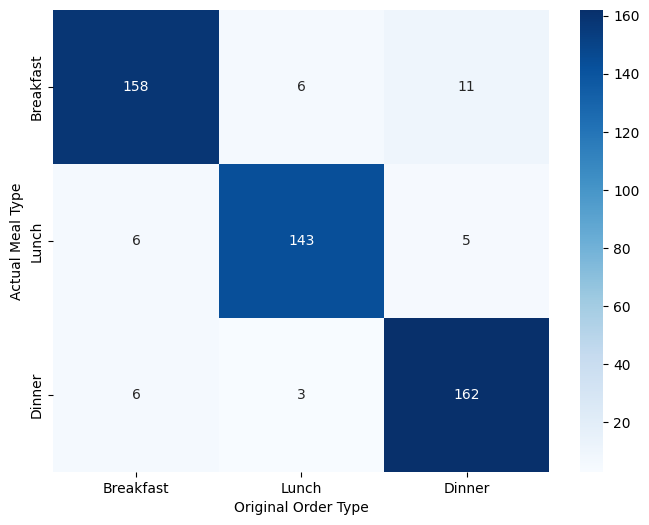

In [85]:
# Create a confusion matrix
conf_matrix = confusion_matrix(dirty_data['order_type'], dirty_data['meal_type'])

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Breakfast', 'Lunch', 'Dinner'],
            yticklabels=['Breakfast', 'Lunch', 'Dinner'])
plt.xlabel('Original Order Type')
plt.ylabel('Actual Meal Type')
plt.show()

In [86]:
# Drop unecessary column
dirty_data.drop(columns=['original_date'], inplace=True)

We’ve noticed discrepancies where the original order type doesn’t align with the timestamp. Let’s specifically examine the instances where the original order type doesn’t match the recorded time.

In [87]:
dirty_data[dirty_data['meal_type'] != dirty_data['order_type']][['order_type','time','meal_type']].head(10)

order_type      time  meal_type
28   Breakfast  12:43:56      Lunch
32   Breakfast  16:06:45     Dinner
43      Dinner  08:20:16  Breakfast
45      Dinner  10:11:49  Breakfast
75       Lunch  19:49:51     Dinner
80       Lunch  09:31:16  Breakfast
88   Breakfast  14:55:46      Lunch
109      Lunch  10:01:41  Breakfast
111  Breakfast  14:15:12      Lunch
124      Lunch  10:11:49  Breakfast

In [88]:
# Combine the modified rows to a new dataset above
mismatched_rows = dirty_data[dirty_data['order_type'] != dirty_data['meal_type']]
mismatched_rows['order_type'] = mismatched_rows['meal_type']

combined_modified_rows = pd.concat([modified_rows, mismatched_rows])

# Check for duplicate order_id values in the combined modified rows
duplicate_order_ids = combined_modified_rows[combined_modified_rows.duplicated(subset=['order_id'])]
duplicate_order_ids

Empty DataFrame
Columns: [order_id, date, time, order_type, branch_code, order_items, order_price, customer_lat, customer_lon, customerHasloyalty?, distance_to_customer_KM, delivery_fee, original_date, meal_type]
Index: []

In [89]:
mismatched_rows.shape

(37, 13)

In [90]:
combined_modified_rows.drop(columns=['meal_type', 'original_date'], inplace=True)

In [91]:
# Replace order_type
dirty_data['order_type'] = dirty_data['meal_type']

# Delete the meal_type column
dirty_data.drop(columns=['meal_type'], inplace=True)

### 2.2.3. Order Price <a class="anchor" name="op"></a>

To get the items' unit price, we implement an iterative method that continuously samples random subsets from the entire dataset and computes the least squares solution. Each iteration compares whether the new solution’s error is smaller than the previous one and updates the predicted values if there’s a significant improvement in the error. Iteration continues until the change in error falls below a set threshold (e.g., 0.001) or reaches the maximum iteration limit. This approach enables finer adjustments to the prediction model, especially useful when dealing with noisy or outlier-prone data.

In [92]:
dirty_data['order_items'] = dirty_data['order_items'].apply(ast.literal_eval)
outliers['order_items'] = outliers['order_items'].apply(eval)

# Function to extract all unique items
def get_unique_items(data):
    item_set = set()
    for items in data['order_items']:
        for item, quantity in items:
            item_set.add(item)
    return sorted(item_set)

# Function to build matrices from sampled data
def build_matrices(data, item_list):
    A = []
    b = []
    for index, row in data.iterrows():
        order_vector = [0] * len(item_list)
        for item, quantity in row['order_items']:
            order_vector[item_list.index(item)] = quantity
        A.append(order_vector)
        b.append(row['order_price'])
    return np.array(A), np.array(b)

# Function to perform iterative sampling and error correction
def iterative_least_squares(data, tolerance=0.001, max_iterations=100000, sample_size=50, seed = None):
    if seed is not None:
        np.random.seed(seed)

    item_list = get_unique_items(data)
    current_solution = np.zeros(len(item_list))
    min_residuals = np.inf

    for iteration in range(max_iterations):
        sample_data = data.sample(n=sample_size)
        A, b = build_matrices(sample_data, item_list)
        x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

        # Check if there is a new residual and if it's better
        if residuals.size > 0 and residuals[0] < min_residuals:
            improvement = min_residuals - residuals[0]
            min_residuals = residuals[0]
            current_solution = x
            # Check for convergence
            if improvement < tolerance:
                break

    return dict(zip(item_list, current_solution))

# item_prices = iterative_least_squares(dirty_data)
item_prices = iterative_least_squares(outliers, seed = 123)


In [93]:
item_prices

{'Burger': 31.00000000000004,
 'Cereal': 20.99999999999997,
 'Chicken': 32.00000000000002,
 'Coffee': 7.4999999999999964,
 'Eggs': 21.999999999999975,
 'Fish&Chips': 35.0,
 'Fries': 12.000000000000023,
 'Pancake': 24.249999999999986,
 'Pasta': 27.499999999999964,
 'Salad': 17.199999999999957,
 'Salmon': 41.00000000000003,
 'Shrimp': 53.99999999999996,
 'Steak': 45.000000000000014}

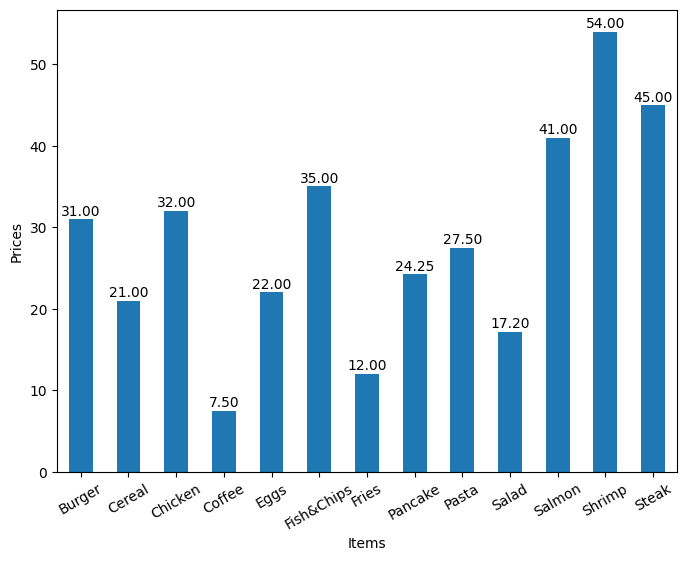

In [94]:
# Convert dictionary to Series
item_prices_series = pd.Series(item_prices)

plt.figure(figsize=(8,6))
item_prices_series.plot(kind='bar')
plt.xlabel('Items')
plt.ylabel('Prices')
plt.xticks(rotation=30)
for i, v in enumerate(item_prices_series):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')
plt.show()

### 2.2.4. Order items <a class="anchor" name="oi"></a>

In [95]:
def clean_order_items(row):
    # Define menus for each meal type based on outlier_data
    menus = {
        'Breakfast': ['Eggs', 'Pancake', 'Coffee', 'Cereal'],
        'Lunch': ['Chicken', 'Burger', 'Salad', 'Fries', 'Steak'],
        'Dinner': ['Pasta', 'Salmon', 'Shrimp', 'Fish&Chips']
    }
    menu = set(menus[row['order_type']])

    # Evaluate the string representation of list of tuples if necessary
    items = eval(row['order_items']) if isinstance(row['order_items'], str) else row['order_items']
    cleaned_items = [(item, quantity) for item, quantity in items if item in menu]

    # Check if any items were removed
    items_removed = len(cleaned_items) != len(items)

    cleaned_items_str = str(cleaned_items) if isinstance(row['order_items'], str) else cleaned_items
    # Filter the quantities of items that are not in the menu and join them into a single string
    remove_string = ''.join(str(quantity) for item, quantity in items if item not in menu)

    # Convert the resulting string to an integer
    remove = int(remove_string) if remove_string else 0  # Ensure we handle the empty string case

    return cleaned_items_str, items_removed, remove

In [96]:
dirty_data[['cleaned_order_items', 'items_removed', 'quantity']] = dirty_data.apply(clean_order_items, axis=1, result_type='expand')

In [97]:
dirty_data[dirty_data['items_removed'] == True].head()

order_id       date      time order_type branch_code  \
42  ORDY09896 2018-08-16  15:26:11      Lunch          TP   
46  ORDX01111 2018-01-23  08:40:33  Breakfast          BK   
87  ORDI03448 2018-10-23  17:48:10     Dinner          NS   
92  ORDZ10950 2018-08-23  15:46:28      Lunch          NS   
93  ORDK07537 2018-05-03  12:03:22      Lunch          BK   

                                          order_items  order_price  \
42  [(Steak, 1), (Salad, 4), (Salmon, 9), (Burger,...       283.80   
46         [(Pancake, 7), (Cereal, 4), (Chicken, 10)]       473.75   
87                           [(Eggs, 7), (Shrimp, 2)]       395.00   
92  [(Salad, 9), (Burger, 4), (Coffee, 7), (Fries,...       586.80   
93  [(Steak, 9), (Coffee, 7), (Salad, 2), (Chicken...       756.40   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
42    -37.810180    144.997128                    0                   10.786   
46    -37.799296    144.935451                    0                   10.126   
87    -37.808243    144.948189                    0                    8.825   
92    -37.820149    144.968759                    0                    8.607   
93    -37.816297    144.963792                    0                    7.786   

    delivery_fee                                cleaned_order_items  \
42     13.847291              [(Steak, 1), (Salad, 4), (Burger, 2)]   
46     15.197027                        [(Pancake, 7), (Cereal, 4)]   
87     15.071605                                      [(Shrimp, 2)]   
92     13.759638              [(Salad, 9), (Burger, 4), (Fries, 7)]   
93     14.026254  [(Steak, 9), (Salad, 2), (Chicken, 2), (Fries,...   

    items_removed  quantity  
42           True         9  
46           True        10  
87           True         7  
92           True         7  
93           True         7

In [98]:
# Define a function to calculate total order price
def calculate_total_price(order_items):
    total_price = 0
    for item, quantity in order_items:
        if item in item_prices:
            total_price += item_prices[item] * quantity
    return total_price

Some of the items in order_items are not on the menu of that order_type. Also, knowing that 1 row can only have 1 anomaly, we know that the order_price and quantity in the order items are correct. Hence, we use that to calculate the price of the missing item and, based on the item price list calculated above, determine the item.

In [99]:
# Function to find matching item and update cleaned_order_items
def add_matching_item(filtered, item_prices):
    updated_items = []
    for index, row in filtered.iterrows():
      if row['items_removed'] == True:
        total_price = calculate_total_price(row['cleaned_order_items'])
        diff = (row['order_price'] - total_price) / row['quantity']

        for item, price in item_prices.items():
            if round(price, 2) == round(diff, 2):
                row['cleaned_order_items'].append((item, row['quantity']))  # Add the matching item
                break
        updated_items.append(row['cleaned_order_items'])
      else:
        updated_items.append(row['order_items'])

    filtered['order_items'] = updated_items

    return filtered

# Update the filtered DataFrame with the matching item
dirty_data = add_matching_item(dirty_data, item_prices)

Manually recalculated and verify it is correct

In [100]:
removed_rows = dirty_data[dirty_data['items_removed'] == True]
removed_rows.head()

order_id       date      time order_type branch_code  \
42  ORDY09896 2018-08-16  15:26:11      Lunch          TP   
46  ORDX01111 2018-01-23  08:40:33  Breakfast          BK   
87  ORDI03448 2018-10-23  17:48:10     Dinner          NS   
92  ORDZ10950 2018-08-23  15:46:28      Lunch          NS   
93  ORDK07537 2018-05-03  12:03:22      Lunch          BK   

                                          order_items  order_price  \
42  [(Steak, 1), (Salad, 4), (Burger, 2), (Fries, 9)]       283.80   
46            [(Pancake, 7), (Cereal, 4), (Eggs, 10)]       473.75   
87                         [(Shrimp, 2), (Salmon, 7)]       395.00   
92  [(Salad, 9), (Burger, 4), (Fries, 7), (Chicken...       586.80   
93  [(Steak, 9), (Salad, 2), (Chicken, 2), (Fries,...       756.40   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
42    -37.810180    144.997128                    0                   10.786   
46    -37.799296    144.935451                    0                   10.126   
87    -37.808243    144.948189                    0                    8.825   
92    -37.820149    144.968759                    0                    8.607   
93    -37.816297    144.963792                    0                    7.786   

    delivery_fee                                cleaned_order_items  \
42     13.847291  [(Steak, 1), (Salad, 4), (Burger, 2), (Fries, 9)]   
46     15.197027            [(Pancake, 7), (Cereal, 4), (Eggs, 10)]   
87     15.071605                         [(Shrimp, 2), (Salmon, 7)]   
92     13.759638  [(Salad, 9), (Burger, 4), (Fries, 7), (Chicken...   
93     14.026254  [(Steak, 9), (Salad, 2), (Chicken, 2), (Fries,...   

    items_removed  quantity  
42           True         9  
46           True        10  
87           True         7  
92           True         7  
93           True         7

In [101]:
combined_modified_rows = pd.concat([combined_modified_rows, removed_rows])

duplicate_order_ids = combined_modified_rows[combined_modified_rows.duplicated(subset=['order_id'])]
duplicate_order_ids

Empty DataFrame
Columns: [order_id, date, time, order_type, branch_code, order_items, order_price, customer_lat, customer_lon, customerHasloyalty?, distance_to_customer_KM, delivery_fee, cleaned_order_items, items_removed, quantity]
Index: []

In [102]:
removed_rows.shape

(37, 15)

In [103]:
dirty_data = dirty_data.drop(columns=['cleaned_order_items', 'items_removed', 'quantity'])

In [104]:
combined_modified_rows = combined_modified_rows.drop(columns=['cleaned_order_items', 'items_removed', 'quantity'])

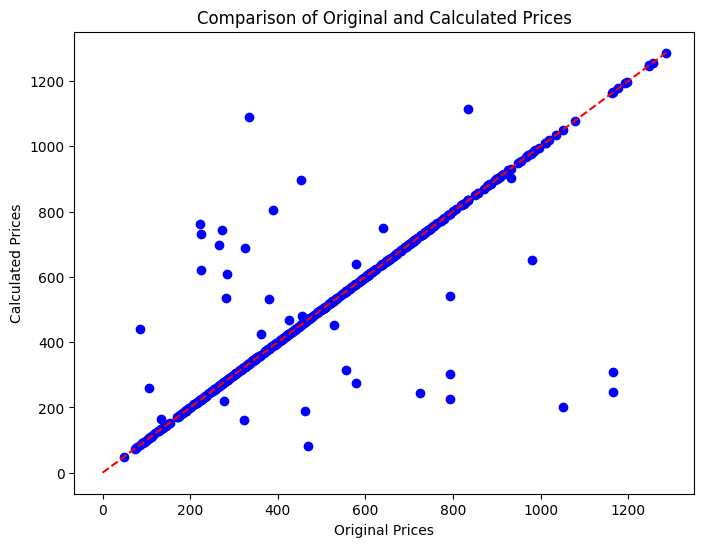

In [105]:
# Apply this function to each row in the dataFrame to compute the estimated order prices
dirty_data['calculated_order_price'] = dirty_data['order_items'].apply(calculate_total_price)

plt.figure(figsize=(8, 6))
plt.scatter(dirty_data['order_price'], dirty_data['calculated_order_price'], color='blue', label='Original vs Calculated Prices')

# Add a 45-degree angle red line
plt.plot([0, dirty_data['order_price'].max()], [0, dirty_data['order_price'].max()], color='red', linestyle='--')

plt.xlabel('Original Prices')
plt.ylabel('Calculated Prices')
plt.title('Comparison of Original and Calculated Prices')
plt.show()

From the plot, it’s evident that several points deviate from the lines indicating that the order_price column may contain dirty data. To investigate further, we’ll select these rows for closer examination.

In [106]:
modified = dirty_data[dirty_data['order_price']!= dirty_data['calculated_order_price'].round(2)]
modified.head(20)

order_id       date      time order_type branch_code  \
12   ORDJ00859 2018-12-18  19:39:43     Dinner          TP   
29   ORDI01699 2018-01-12  08:20:16  Breakfast          NS   
35   ORDY09111 2018-04-11  11:12:40  Breakfast          TP   
41   ORDC09244 2018-12-17  19:39:43     Dinner          NS   
49   ORDY01711 2018-03-22  10:32:06  Breakfast          TP   
60   ORDK08769 2018-11-23  18:49:00     Dinner          BK   
64   ORDX07889 2018-06-02  13:04:13      Lunch          BK   
76   ORDX00242 2018-09-08  16:16:54     Dinner          BK   
105  ORDB03393 2018-05-23  12:43:56      Lunch          TP   
119  ORDC02482 2018-01-11  08:20:16  Breakfast          NS   
135  ORDI00260 2018-02-19  09:31:16  Breakfast          NS   
155  ORDJ03991 2018-08-22  15:46:28      Lunch          TP   
159  ORDI03596 2018-02-10  09:21:07  Breakfast          NS   
169  ORDB06330 2018-07-31  14:55:46      Lunch          TP   
170  ORDB05844 2018-03-01  09:51:32  Breakfast          TP   
180  ORDA06043 2018-02-15  09:21:07  Breakfast          BK   
214  ORDC05609 2018-12-16  19:29:34     Dinner          NS   
217  ORDI05984 2018-01-07  08:10:08  Breakfast          NS   
219  ORDB04066 2018-08-03  15:05:54      Lunch          TP   
254  ORDJ01645 2018-01-25  08:40:33  Breakfast          TP   

                                           order_items  order_price  \
12   [(Shrimp, 7), (Pasta, 6), (Salmon, 3), (Fish&C...       388.00   
29             [(Eggs, 8), (Cereal, 1), (Pancake, 10)]        86.00   
35                         [(Pancake, 4), (Cereal, 5)]      1050.00   
41   [(Fish&Chips, 10), (Shrimp, 6), (Salmon, 4), (...       834.00   
49            [(Pancake, 8), (Coffee, 3), (Cereal, 2)]       107.00   
60          [(Shrimp, 8), (Fish&Chips, 1), (Pasta, 8)]       325.00   
64              [(Chicken, 1), (Fries, 6), (Salad, 7)]       792.00   
76         [(Shrimp, 7), (Fish&Chips, 8), (Salmon, 1)]       265.75   
105                           [(Steak, 9), (Salad, 8)]       792.00   
119                          [(Eggs, 3), (Cereal, 10)]       577.50   
135  [(Cereal, 6), (Coffee, 8), (Eggs, 6), (Pancake...       282.00   
155            [(Steak, 3), (Burger, 6), (Chicken, 5)]       456.00   
159  [(Cereal, 4), (Coffee, 6), (Pancake, 5), (Eggs...       362.00   
169            [(Fries, 10), (Steak, 8), (Chicken, 4)]       283.80   
170                           [(Eggs, 2), (Coffee, 5)]       468.40   
180                        [(Coffee, 2), (Pancake, 6)]       322.75   
214  [(Shrimp, 10), (Fish&Chips, 2), (Pasta, 4), (S...       333.50   
217                        [(Pancake, 4), (Coffee, 9)]       132.75   
219  [(Salad, 6), (Chicken, 5), (Fries, 3), (Steak,...       640.60   
254             [(Coffee, 2), (Pancake, 4), (Eggs, 6)]       724.20   

     customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
12     -37.808830    144.946545                    0                    9.790   
29     -37.821145    144.947436                    1                    9.834   
35     -37.823580    144.967388                    0                    7.843   
41     -37.807718    144.952086                    0                    8.461   
49     -37.805947    144.947313                    0                    9.843   
60     -37.795314    144.993745                    0                    6.512   
64     -37.816659    144.969771                    0                    7.198   
76     -37.815730    144.938037                    0                    9.942   
105    -37.814526    145.015511                    0                   13.066   
119    -37.807260    144.957396                    1                    8.099   
135    -37.807166    144.946179                    0                    8.883   
155    -37.811398    144.949462                    0                    9.398   
159    -37.808805    144.966436                    0                    7.165   
169    -37.803168    144.973449                    0                    9.814

In [107]:
# Replace order_price
dirty_data['order_price'] = dirty_data['calculated_order_price']

modified['order_price'] = modified['calculated_order_price']

In [108]:
combined_modified_rows = pd.concat([combined_modified_rows, modified])

duplicate_order_ids = combined_modified_rows[combined_modified_rows.duplicated(subset=['order_id'])]
duplicate_order_ids

Empty DataFrame
Columns: [order_id, date, time, order_type, branch_code, order_items, order_price, customer_lat, customer_lon, customerHasloyalty?, distance_to_customer_KM, delivery_fee, calculated_order_price]
Index: []

In [109]:
modified.shape

(37, 13)

In [110]:
# Delete the calculated_order_price column
dirty_data.drop(columns=['calculated_order_price'], inplace=True)
combined_modified_rows.drop(columns=['calculated_order_price'], inplace=True)

In [111]:
dirty_data.head()

order_id       date      time order_type branch_code  \
0  ORDJ05322 2018-09-16  16:27:02     Dinner          TP   
1  ORDZ03710 2018-11-19  18:38:52     Dinner          NS   
2  ORDI06352 2018-02-02  09:00:50  Breakfast          NS   
3  ORDA02915 2018-06-09  13:14:21      Lunch          bk   
4  ORDY05327 2018-12-04  19:09:17     Dinner          TP   

                                  order_items  order_price  customer_lat  \
0      [(Shrimp, 8), (Pasta, 8), (Salmon, 5)]        857.0    -37.804173   
1              [(Fish&Chips, 1), (Shrimp, 3)]        197.0    -37.800661   
2                   [(Coffee, 10), (Eggs, 7)]        229.0    -37.817054   
3                   [(Steak, 5), (Burger, 5)]        380.0    -37.826095   
4  [(Fish&Chips, 9), (Salmon, 9), (Pasta, 1)]        711.5    -37.821908   

   customer_lon  customerHasloyalty?  distance_to_customer_KM  delivery_fee  
0    144.964366                    0                    9.373     14.327731  
1    144.985561                    0                    7.655     13.507825  
2    144.953322                    0                    8.954     13.843901  
3    144.958049                    0                    9.078     17.220138  
4    144.971227                    0                    7.936     12.576641

### 2.2.5. Customer_lat & Customer_lon <a class="anchor" name="ll"></a>

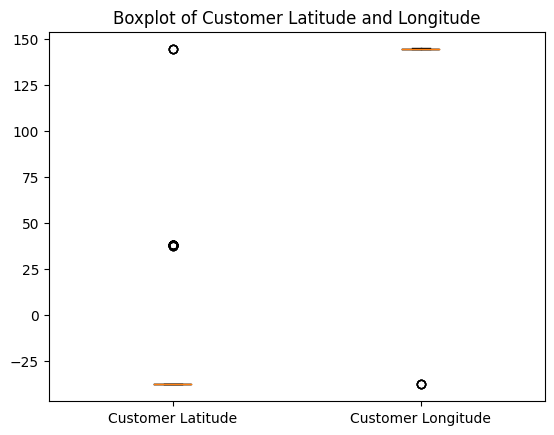

In [112]:
fig, ax = plt.subplots()
ax.boxplot([dirty_data['customer_lat'], dirty_data['customer_lon']], labels=['Customer Latitude', 'Customer Longitude'])
ax.set_title('Boxplot of Customer Latitude and Longitude')
plt.show()

In this plot, we can clearly see that there are significant outliers present in the `customer_lat` and `customer_lon` columns.

In [113]:
def identify_outliers(data, multiplier=1.5):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

# Identify outliers in customer_lat and customer_lon
lat_outliers = identify_outliers(dirty_data['customer_lat'], multiplier=5000)
lon_outliers = identify_outliers(dirty_data['customer_lon'], multiplier=10000)

# Filter dirty_data to get rows where either customer_lat or customer_lon is an outlier
outlier_rows = dirty_data[lat_outliers | lon_outliers]
outlier_rows.head()

order_id       date      time order_type branch_code  \
13  ORDB01305 2018-11-27  18:59:09     Dinner          TP   
39  ORDJ00205 2018-06-14  13:24:30      Lunch          TP   
56  ORDZ07658 2018-09-13  16:27:02     Dinner          NS   
61  ORDZ07026 2018-09-27  16:57:27     Dinner          NS   
62  ORDZ05008 2018-01-08  08:10:08  Breakfast          NS   

                                          order_items  order_price  \
13                          [(Pasta, 8), (Salmon, 2)]        302.0   
39  [(Burger, 2), (Steak, 2), (Chicken, 7), (Fries...        424.0   
56                          [(Pasta, 7), (Salmon, 2)]        274.5   
61                      [(Fish&Chips, 5), (Pasta, 1)]        202.5   
62                          [(Eggs, 9), (Pancake, 4)]        295.0   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
13     37.816154    144.945432                    0                    9.502   
39     37.800079    144.967117                    0                    9.868   
56     37.800801    144.953491                    0                    7.690   
61     37.798812    144.948918                    0                    8.205   
62     37.809135    144.981439                    1                    7.918   

    delivery_fee  
13     13.060091  
39     13.200960  
56     14.259903  
61     14.523930  
62      6.331109

The primary reason for these outliers is that two columns of data have been swapped or the latitude has been mistakenly made positive, so we need to adjust them accordingly

In [114]:
outlier_rows.loc[outlier_rows['customer_lat'] > 100, ['customer_lat', 'customer_lon']].shape

(4, 2)

In [115]:
# Swap customer_lat and customer_lon columns for rows where latitude is greater than 100
outlier_rows.loc[outlier_rows['customer_lat'] > 100, ['customer_lat', 'customer_lon']] = outlier_rows.loc[outlier_rows['customer_lat'] > 100, ['customer_lon', 'customer_lat']].values


In [116]:
outlier_rows.loc[outlier_rows['customer_lat'] > 0, 'customer_lat'].shape

(37,)

In [117]:
# Adjust latitude for all outliers by multiplying by -1
outlier_rows.loc[outlier_rows['customer_lat'] > 0, 'customer_lat'] *= -1

In [118]:
outlier_rows.head(10)

order_id       date      time order_type branch_code  \
13  ORDB01305 2018-11-27  18:59:09     Dinner          TP   
39  ORDJ00205 2018-06-14  13:24:30      Lunch          TP   
56  ORDZ07658 2018-09-13  16:27:02     Dinner          NS   
61  ORDZ07026 2018-09-27  16:57:27     Dinner          NS   
62  ORDZ05008 2018-01-08  08:10:08  Breakfast          NS   
63  ORDJ07902 2018-02-03  09:00:50  Breakfast          TP   
72  ORDY02335 2018-08-25  15:46:28      Lunch          TP   
82  ORDC06089 2018-07-27  14:45:38      Lunch          NS   
94  ORDZ07328 2018-11-26  18:49:00     Dinner          NS   
99  ORDX08014 2018-08-18  15:36:20      Lunch          BK   

                                          order_items  order_price  \
13                          [(Pasta, 8), (Salmon, 2)]       302.00   
39  [(Burger, 2), (Steak, 2), (Chicken, 7), (Fries...       424.00   
56                          [(Pasta, 7), (Salmon, 2)]       274.50   
61                      [(Fish&Chips, 5), (Pasta, 1)]       202.50   
62                          [(Eggs, 9), (Pancake, 4)]       295.00   
63                        [(Coffee, 8), (Pancake, 3)]       132.75   
72  [(Chicken, 5), (Burger, 6), (Fries, 6), (Salad...       902.40   
82  [(Burger, 4), (Salad, 6), (Steak, 9), (Fries, 3)]       668.20   
94  [(Fish&Chips, 7), (Salmon, 10), (Pasta, 6), (S...      1198.00   
99                          [(Burger, 9), (Fries, 8)]       375.00   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
13    -37.816154    144.945432                    0                    9.502   
39    -37.800079    144.967117                    0                    9.868   
56    -37.800801    144.953491                    0                    7.690   
61    -37.798812    144.948918                    0                    8.205   
62    -37.809135    144.981439                    1                    7.918   
63    -37.823188    144.960796                    0                    7.651   
72    -37.817842    144.968706                    0                    8.012   
82    -37.811062    144.988866                    0                    8.607   
94    -37.823133    144.951741                    0                    9.818   
99    -37.809868    144.966684                    0                    7.201   

    delivery_fee  
13     13.060091  
39     13.200960  
56     14.259903  
61     14.523930  
62      6.331109  
63     11.913022  
72     13.647365  
82     14.134363  
94     16.368884  
99     15.915144

In [119]:
dirty_data.update(outlier_rows)

In [120]:
combined_modified_rows = pd.concat([combined_modified_rows, outlier_rows])

duplicate_order_ids = combined_modified_rows[combined_modified_rows.duplicated(subset=['order_id'])]
duplicate_order_ids

Empty DataFrame
Columns: [order_id, date, time, order_type, branch_code, order_items, order_price, customer_lat, customer_lon, customerHasloyalty?, distance_to_customer_KM, delivery_fee]
Index: []

In [121]:
combined_modified_rows.shape

(189, 12)

### 2.2.6. Distance and Branch code <a class="anchor" name="db"></a>

In [122]:
# Create a copy of the original DataFrame before modification
original_dirty_data = dirty_data.copy()

# Convert the branch_code column to uppercase
dirty_data['branch_code'] = dirty_data['branch_code'].str.upper()

In [123]:
# Create a graph
G = nx.Graph()

# Add nodes
for index, row in nodes.iterrows():
    G.add_node(row['node'], pos=(row['lat'], row['lon']))

# Add edges
for index, row in edges.iterrows():
    G.add_edge(row['u'], row['v'], weight=row['distance(m)'])

In [124]:
# Build a k-d tree for efficient nearest neighbor search
coords = nodes[['lat', 'lon']].values
kdtree = KDTree(coords)

In [125]:
# Function to find the closest node using k-d tree
def find_closest_node_kdtree(lat, lon, nodes, kdtree):
    dist, ind = kdtree.query([[lat, lon]], k=1)
    closest_node_idx = ind[0][0]
    return nodes.iloc[closest_node_idx]['node']

In [126]:
# Function to calculate shortest path for each order
def calculate_shortest_path(index, row, nodes, branches, kdtree, G):
    customer_lat = row["customer_lat"]
    customer_lon = row["customer_lon"]
    branch_code = row["branch_code"]

    # Find the closest graph node to the customer's location using the KDTree
    closest_customer_node = find_closest_node_kdtree(customer_lat, customer_lon, nodes, kdtree)

    # Find the branch row corresponding to the branch code
    branch_row = branches[branches['branch_code'] == branch_code]
    if not branch_row.empty:
        # Get the branch's latitude and longitude
        branch_lat = branch_row.iloc[0]['branch_lat']
        branch_lon = branch_row.iloc[0]['branch_lon']
        # Find the closest graph node to the branch's location using the KDTree
        closest_branch_node = find_closest_node_kdtree(branch_lat, branch_lon, nodes, kdtree)

         # If both the customer and branch nodes are found
        if closest_customer_node and closest_branch_node:
          # Calculate the shortest path length between the nodes using Dijkstra's algorithm
            shortest_path_length = nx.dijkstra_path_length(G, closest_customer_node, closest_branch_node, weight='weight')
            return shortest_path_length / 1000  # Convert meters to kilometers
    return None

In [127]:
# Calculate shortest paths for each order
for index, row in dirty_data.iterrows():
    shortest_path_km = calculate_shortest_path(index, row, nodes, branch, kdtree, G)
    if shortest_path_km is not None:
        dirty_data.at[index, "calculated_distance_to_customer_KM"] = shortest_path_km
        dirty_data.at[index, "distance_discrepancy"] = row["distance_to_customer_KM"] - shortest_path_km

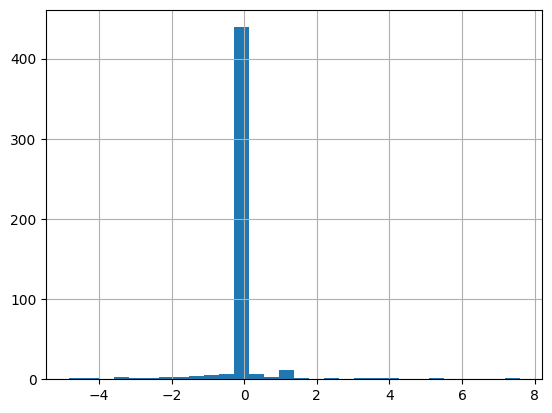

In [128]:
dirty_data['distance_discrepancy'].hist(bins=30)
plt.show()

In [129]:
dirty_data.head()

order_id       date      time order_type branch_code  \
0  ORDJ05322 2018-09-16  16:27:02     Dinner          TP   
1  ORDZ03710 2018-11-19  18:38:52     Dinner          NS   
2  ORDI06352 2018-02-02  09:00:50  Breakfast          NS   
3  ORDA02915 2018-06-09  13:14:21      Lunch          BK   
4  ORDY05327 2018-12-04  19:09:17     Dinner          TP   

                                  order_items  order_price  customer_lat  \
0      [(Shrimp, 8), (Pasta, 8), (Salmon, 5)]        857.0    -37.804173   
1              [(Fish&Chips, 1), (Shrimp, 3)]        197.0    -37.800661   
2                   [(Coffee, 10), (Eggs, 7)]        229.0    -37.817054   
3                   [(Steak, 5), (Burger, 5)]        380.0    -37.826095   
4  [(Fish&Chips, 9), (Salmon, 9), (Pasta, 1)]        711.5    -37.821908   

   customer_lon  customerHasloyalty?  distance_to_customer_KM  delivery_fee  \
0    144.964366                    0                    9.373     14.327731   
1    144.985561                    0                    7.655     13.507825   
2    144.953322                    0                    8.954     13.843901   
3    144.958049                    0                    9.078     17.220138   
4    144.971227                    0                    7.936     12.576641   

   calculated_distance_to_customer_KM  distance_discrepancy  
0                               9.373                   0.0  
1                               7.655                   0.0  
2                               8.954                   0.0  
3                               9.078                   0.0  
4                               7.936                   0.0

With the records that have a distance discrepancy (value between the newly calculated distance and the original distance) different from 0, we will first check if the branch code is correct and then adjust the distance if the branch is correct.

In [130]:
def find_nearest_branch(customer_lat, customer_lon, nodes_df, branches_df, G):
    closest_customer_node = find_closest_node_kdtree(customer_lat, customer_lon, nodes_df, kdtree)
    distances = {}

    for _, branch_row in branch.iterrows():
        branch_lat = branch_row['branch_lat']
        branch_lon = branch_row['branch_lon']
        branch_code = branch_row['branch_code']

        closest_branch_node = find_closest_node_kdtree(branch_lat, branch_lon, nodes_df, kdtree)

        if closest_customer_node and closest_branch_node:
            try:
                shortest_path_length = nx.dijkstra_path_length(G, closest_customer_node, closest_branch_node)
                distances[branch_code] = shortest_path_length / 1000  # Convert meters to kilometers
            except nx.NetworkXNoPath:
                distances[branch_code] = np.nan

    return distances

In [131]:
#Filter out the rows that currently have mismatched original distance and calculated distance
filtered_row = dirty_data[dirty_data['distance_discrepancy'] != 0]

In [132]:
filtered_row.head(10)

order_id       date      time order_type branch_code  \
16  ORDJ05085 2018-11-04  18:08:27     Dinner          NS   
27  ORDB04498 2018-04-27  11:43:05  Breakfast          BK   
38  ORDI09858 2018-07-17  14:25:21      Lunch          NS   
47  ORDC02193 2018-03-28  10:42:15  Breakfast          BK   
48  ORDJ05848 2018-01-07  08:10:08  Breakfast          TP   
53  ORDB09183 2018-12-07  19:19:26     Dinner          TP   
57  ORDC02111 2018-06-18  13:34:38      Lunch          NS   
66  ORDB01088 2018-01-20  08:30:25  Breakfast          TP   
70  ORDB08586 2018-05-05  12:03:22      Lunch          TP   
81  ORDC07985 2018-11-01  17:58:18     Dinner          NS   

                                          order_items  order_price  \
16  [(Fish&Chips, 1), (Shrimp, 3), (Pasta, 7), (Sa...       635.50   
27  [(Cereal, 5), (Pancake, 5), (Eggs, 2), (Coffee...       322.75   
38  [(Steak, 9), (Fries, 9), (Burger, 3), (Salad, ...       906.00   
47              [(Coffee, 8), (Eggs, 9), (Cereal, 8)]       426.00   
48           [(Pancake, 9), (Coffee, 6), (Cereal, 2)]       305.25   
53         [(Shrimp, 6), (Fish&Chips, 1), (Pasta, 7)]       551.50   
57  [(Steak, 9), (Chicken, 6), (Fries, 4), (Burger...      1010.00   
66                          [(Pancake, 5), (Eggs, 6)]       253.25   
70  [(Chicken, 9), (Steak, 10), (Fries, 5), (Burge...       984.00   
81                          [(Shrimp, 6), (Pasta, 3)]       406.50   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
16    -37.818700    144.953146                    0                    8.541   
27    -37.812297    145.004958                    0                   11.407   
38    -37.821006    144.944280                    0                    6.941   
47    -37.814220    144.964953                    0                    8.022   
48    -37.813334    144.936812                    1                    8.146   
53    -37.801682    144.981386                    0                    9.834   
57    -37.799557    144.955338                    0                    7.207   
66    -37.799101    144.933486                    0                    9.674   
70    -37.819620    144.994368                    0                    8.060   
81    -37.818326    144.996913                    0                    7.690   

    delivery_fee  calculated_distance_to_customer_KM  distance_discrepancy  
16     14.025397                               9.223                -0.682  
27     13.969828                               3.825                 7.582  
38     15.374375                              10.008                -3.067  
47     13.207870                               7.666                 0.356  
48      6.860162                              10.466                -2.320  
53     14.138111                              10.309                -0.475  
57     12.682489                               7.464                -0.257  
66     15.212287                              11.453                -1.779  
70     14.740447                              10.126                -2.066  
81     15.934194                               9.849                -2.159

Within these filter rows, if there is a branch that has exact match distance to the original distance, then change the branch code. Otherwise, update the new distance

In [133]:
# Check if the branch code is correct for orders with distance discrepancy
for index, row in filtered_row.iterrows():
    customer_lat = row["customer_lat"]
    customer_lon = row["customer_lon"]

    distances = find_nearest_branch(customer_lat, customer_lon, nodes, branch, G)

    matched_branch_code = None
    matched_distance = None
    for branch_code, distance in distances.items():
        filtered_row.at[index, f"distance_to_{branch_code}"] = distance
        if np.isclose(row['distance_to_customer_KM'], distance, atol = 0.01):
            matched_branch_code = branch_code
            matched_distance = distance
            break

    if matched_branch_code:
        # Update branch code if a match is found
        filtered_row.at[index, "branch_code"] = matched_branch_code
        filtered_row.at[index, "distance_to_customer_KM"] = matched_distance
    else:
        # Otherwise, update the distance to the newly calculated one
        filtered_row.at[index, "distance_to_customer_KM"] = row["calculated_distance_to_customer_KM"]

In [134]:
filtered_row.head(50)

order_id       date      time order_type branch_code  \
16   ORDJ05085 2018-11-04  18:08:27     Dinner          TP   
27   ORDB04498 2018-04-27  11:43:05  Breakfast          TP   
38   ORDI09858 2018-07-17  14:25:21      Lunch          NS   
47   ORDC02193 2018-03-28  10:42:15  Breakfast          NS   
48   ORDJ05848 2018-01-07  08:10:08  Breakfast          TP   
53   ORDB09183 2018-12-07  19:19:26     Dinner          TP   
57   ORDC02111 2018-06-18  13:34:38      Lunch          NS   
66   ORDB01088 2018-01-20  08:30:25  Breakfast          TP   
70   ORDB08586 2018-05-05  12:03:22      Lunch          TP   
81   ORDC07985 2018-11-01  17:58:18     Dinner          NS   
85   ORDY04045 2018-07-20  14:35:29      Lunch          TP   
86   ORDJ08645 2018-05-30  12:54:05      Lunch          TP   
108  ORDJ06600 2018-09-07  16:16:54     Dinner          TP   
126  ORDX06062 2018-11-15  18:28:43     Dinner          BK   
138  ORDY08588 2018-07-19  14:35:29      Lunch          TP   
141  ORDZ05021 2018-10-06  17:17:44     Dinner          NS   
145  ORDJ05386 2018-01-16  08:30:25  Breakfast          TP   
147  ORDY10328 2018-07-31  14:55:46      Lunch          TP   
160  ORDY03349 2018-04-24  11:43:05  Breakfast          TP   
162  ORDZ08305 2018-10-15  17:27:53     Dinner          NS   
176  ORDA02533 2018-12-07  19:19:26     Dinner          BK   
178  ORDJ06408 2018-06-09  13:14:21      Lunch          TP   
184  ORDC00018 2018-02-03  09:00:50  Breakfast          NS   
186  ORDZ04860 2018-06-13  13:24:30      Lunch          NS   
195  ORDX06053 2018-09-04  16:06:45     Dinner          BK   
200  ORDC05526 2018-08-21  15:36:20      Lunch          NS   
205  ORDX08031 2018-06-29  13:54:55      Lunch          BK   
209  ORDZ04862 2018-07-04  14:05:04      Lunch          NS   
212  ORDA00360 2018-02-02  09:00:50  Breakfast          NS   
218  ORDY03232 2018-01-08  08:10:08  Breakfast          TP   
227  ORDX10068 2018-03-12  10:11:49  Breakfast          BK   
231  ORDJ02028 2018-02-26  09:51:32  Breakfast          TP   
236  ORDX01233 2018-04-09  11:12:40  Breakfast          BK   
238  ORDI05283 2018-05-08  12:13:31      Lunch          NS   
253  ORDJ01652 2018-10-27  17:58:18     Dinner          TP   
261  ORDY04936 2018-10-06  17:07:36     Dinner          TP   
262  ORDX05727 2018-10-10  17:17:44     Dinner          BK   
264  ORDB09873 2018-01-06  08:10:08  Breakfast          TP   
269  ORDK05563 2018-07-09  14:15:12      Lunch          BK   
270  ORDI10502 2018-01-03  08:00:00  Breakfast          NS   
276  ORDB02303 2018-06-21  13:34:38      Lunch          TP   
277  ORDC10522 2018-10-24  17:48:10     Dinner          NS   
279  ORDI08006 2018-02-01  09:00:50  Breakfast          NS   
288  ORDK01297 2018-08-26  15:46:28      Lunch          BK   
289  ORDA08312 2018-05-15  12:23:39      Lunch          BK   
304  ORDY07822 2018-05-11  12:13:31      Lunch          TP   
308  ORDK03775 2018-07-18  14:35:29      Lunch          BK   
311  ORDY10264 2018-11-24  18:49:00     Dinner          TP   
327  ORDY10825 2018-05-17  12:23:39      Lunch          TP   
336  ORDJ01076 2018-01-24  08:40:33  Breakfast          TP   

                                           order_items  order_price  \
16   [(Fish&Chips, 1), (Shrimp, 3), (Pasta, 7), (Sa...       635.50   
27   [(Cereal, 5), (Pancake, 5), (Eggs, 2), (Coffee...       322.75   
38   [(Steak, 9), (Fries, 9), (Burger, 3), (Salad, ...       906.00   
47               [(Coffee, 8), (Eggs, 9), (Cereal, 8)]       426.00   
48            [(Pancake, 9), (Coffee, 6), (Cereal, 2)]       305.25   
53          [(Shrimp, 6), (Fish&Chips, 1), (Pasta, 7)]       551.50   
57   [(Steak, 9), (Chicken, 6), (Fries, 4), (Burger...      1010.00   
66                           [(Pancake, 5), (Eggs, 6)]       253.25   
70   [(Chicken, 9), (Steak, 10), (Fries, 5), (Burge...       984.00   
81                           [(Shrimp, 6), (Pasta, 3)]       406.50   
85                         [(Chicken, 7), (Burger, 5)]       3

In [135]:
dirty_data.update(filtered_row)

In [136]:
updated_rows = dirty_data[dirty_data['branch_code'] != original_dirty_data['branch_code']]
updated_rows.shape

(37, 14)

#### Distance validation after formatting

In [137]:
for index, row in filtered_row.iterrows():
    shortest_path_km = calculate_shortest_path(index, row, nodes, branch, kdtree, G)
    if shortest_path_km is not None:
        filtered_row.at[index, "calculated_distance_to_customer_KM"] = shortest_path_km
        filtered_row.at[index, "distance_discrepancy"] = row["distance_to_customer_KM"] - shortest_path_km

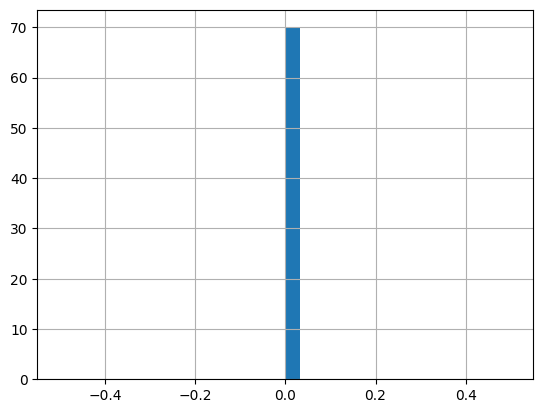

In [138]:
filtered_row['distance_discrepancy'].hist(bins=30)
plt.show()

In [139]:
dirty_data.update(filtered_row)

In [140]:
dirty_data.head()

order_id       date      time order_type branch_code  \
0  ORDJ05322 2018-09-16  16:27:02     Dinner          TP   
1  ORDZ03710 2018-11-19  18:38:52     Dinner          NS   
2  ORDI06352 2018-02-02  09:00:50  Breakfast          NS   
3  ORDA02915 2018-06-09  13:14:21      Lunch          BK   
4  ORDY05327 2018-12-04  19:09:17     Dinner          TP   

                                  order_items  order_price  customer_lat  \
0      [(Shrimp, 8), (Pasta, 8), (Salmon, 5)]        857.0    -37.804173   
1              [(Fish&Chips, 1), (Shrimp, 3)]        197.0    -37.800661   
2                   [(Coffee, 10), (Eggs, 7)]        229.0    -37.817054   
3                   [(Steak, 5), (Burger, 5)]        380.0    -37.826095   
4  [(Fish&Chips, 9), (Salmon, 9), (Pasta, 1)]        711.5    -37.821908   

   customer_lon  customerHasloyalty?  distance_to_customer_KM  delivery_fee  \
0    144.964366                    0                    9.373     14.327731   
1    144.985561                    0                    7.655     13.507825   
2    144.953322                    0                    8.954     13.843901   
3    144.958049                    0                    9.078     17.220138   
4    144.971227                    0                    7.936     12.576641   

   calculated_distance_to_customer_KM  distance_discrepancy  
0                               9.373                   0.0  
1                               7.655                   0.0  
2                               8.954                   0.0  
3                               9.078                   0.0  
4                               7.936                   0.0

In [141]:
updated_rows1 = dirty_data[dirty_data['distance_to_customer_KM'] != original_dirty_data['distance_to_customer_KM']]
updated_rows1.shape

(38, 14)

In [142]:
combined_modified_rows = pd.concat([combined_modified_rows, updated_rows, updated_rows1])

# Check for duplicate
duplicate_order_ids = combined_modified_rows[combined_modified_rows.duplicated(subset=['order_id'])]
duplicate_order_ids

order_id       date      time order_type branch_code  \
212  ORDA00360 2018-02-02  09:00:50  Breakfast          NS   

                   order_items  order_price  customer_lat  customer_lon  \
212  [(Pancake, 8), (Eggs, 4)]        282.0    -37.816396    144.937327   

     customerHasloyalty?  distance_to_customer_KM  delivery_fee  \
212                    0                    10.04     14.697201   

     calculated_distance_to_customer_KM  distance_discrepancy  
212                               10.04                   0.0

In [143]:
combined_modified_rows.shape

(264, 14)

Due to the current loop is not considering the branch that has been upper case formatted, there is this row with order id: ORDA00360 been modified twice

In [144]:
original_distance = original_dirty_data.loc[original_dirty_data['order_id'] == 'ORDA00360', 'distance_to_customer_KM'].values[0]

dirty_data.loc[dirty_data['order_id'] == 'ORDA00360', 'distance_to_customer_KM'] = original_distance

In [145]:
combined_modified_rows = combined_modified_rows.drop_duplicates(subset=['order_id'], keep='first')
combined_modified_rows.shape

(263, 14)

In [146]:
combined_modified_rows.loc[combined_modified_rows['order_id'] == 'ORDA00360', 'distance_to_customer_KM'] = original_distance

### 2.2.7. Model building <a class="anchor" name="model"></a>

In [147]:
#No NA
dirty_data.isna().sum()

order_id                              0
date                                  0
time                                  0
order_type                            0
branch_code                           0
order_items                           0
order_price                           0
customer_lat                          0
customer_lon                          0
customerHasloyalty?                   0
distance_to_customer_KM               0
delivery_fee                          0
calculated_distance_to_customer_KM    0
distance_discrepancy                  0
dtype: int64

We will use several predictors to forecast the delivery fee:

a. Day type: Encoded as a continuous variable where weekends are represented by 1 and weekdays by 0.

b. Time of day: Coded as a continuous variable, with morning as 0, afternoon as 1, and evening as 2.

c. Distance between the branch and customer.

d. Whether the customer has a loyalty membership.

e. The branch

In [148]:
dirty_data.drop(columns=['calculated_distance_to_customer_KM', 'distance_discrepancy'], inplace=True)
combined_modified_rows.drop(columns=['calculated_distance_to_customer_KM', 'distance_discrepancy'], inplace=True)

Since the records in missing data that do not have NAs are all correct. Also, we have created a dataframe that contains the rows that have been changed (knowing 1 row only have 1 anomaly). Hence we combine the cleaned rows in missing data and dirty data and attempt to fit and check whether the anomalies have been correct.

In [149]:
non_missing_data = missing_data.dropna()

In [150]:
combined_data = pd.concat([non_missing_data, combined_modified_rows])

In [151]:
# Ensure date is in datetime format
combined_data['date'] = pd.to_datetime(combined_data['date'])

# Create a feature for weekend/weekday
def get_weekday_or_weekend(date):
    if date.weekday() < 5:
        return 0
    else:
        return 1

combined_data['is_weekend'] = combined_data['date'].apply(get_weekday_or_weekend)

# Create a feature for time of the day
combined_data['time'] = pd.to_datetime(combined_data['time'], format='%H:%M:%S').dt.time
def classify_time(t):
    if time(8, 0) <= t <= time(12, 0):
        return 0
    elif time(12, 0, 1) <= t <= time(16, 0):
        return 1
    elif time(16, 0, 1) <= t <= time(20, 0):
        return 2
    return None
combined_data['time_of_day'] = combined_data['time'].apply(classify_time)

# Adjusted delivery fee
combined_data['adjusted_delivery_fee'] = combined_data.apply(
    lambda row: row['delivery_fee'] * 0.5 if row['customerHasloyalty?'] == 1 else row['delivery_fee'],
    axis=1
)

In [152]:
# Function to train and evaluate a linear regression model for each branch
def train_branch_models(data):
    branches = data['branch_code'].unique()
    models = {}
    for branch in branches:
        branch_data = data[data['branch_code'] == branch]

        # Include customer loyalty as a feature
        X = branch_data[['is_weekend', 'time_of_day', 'distance_to_customer_KM', 'customerHasloyalty?']]
        y = branch_data['delivery_fee']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        # Train the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Store the model
        models[branch] = model

        # Evaluate the model on the test set
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        print(f'Branch: {branch}, R2 Score: {r2:.2f}')
    return models

# Train models for each branch
branch_models = train_branch_models(combined_data)

Branch: BK, R2 Score: 0.98
Branch: NS, R2 Score: 0.98
Branch: TP, R2 Score: 0.98


### 2.2.8. Customer loyalty modification <a class="anchor" name="cl"></a>

Create a function to predict the fee using the trained model to predict the fee for dirty data and cross check the customer loyalty columns, since there might be records having wrong 'customerHasloyalty?' classification.

In [153]:
# Create feature for the dirty data
dirty_data['is_weekend'] = dirty_data['date'].apply(get_weekday_or_weekend)

# Create a feature for time of the day
def classify_time(t):
    if time(8, 0) <= t <= time(12, 0):
        return 0
    elif time(12, 0, 1) <= t <= time(16, 0):
        return 1
    elif time(16, 0, 1) <= t <= time(20, 0):
        return 2
    return None
dirty_data['time_of_day'] = dirty_data['time'].apply(classify_time)

In [154]:
# Function to predict delivery fee with loyalty adjustment
def predict_delivery_fee(row, models):
    branch = row['branch_code']
    model = models.get(branch)
    if model is not None:
        X = np.array([[row['is_weekend'], row['time_of_day'], row['distance_to_customer_KM'], row['customerHasloyalty?']]])
        fee = model.predict(X)[0]
        return fee
    else:
        return np.nan

# Apply the prediction function to the dirty data
dirty_data['predicted_delivery_fee'] = dirty_data.apply(predict_delivery_fee, axis=1, models=branch_models)

In [155]:
dirty_data[['branch_code', 'is_weekend', 'time_of_day', 'distance_to_customer_KM', 'customerHasloyalty?', 'delivery_fee', 'predicted_delivery_fee']].head()

branch_code  is_weekend  time_of_day  distance_to_customer_KM  \
0          TP           1            2                    9.373   
1          NS           0            2                    7.655   
2          NS           0            0                    8.954   
3          BK           1            1                    9.078   
4          TP           0            2                    7.936   

   customerHasloyalty?  delivery_fee  predicted_delivery_fee  
0                    0     14.327731               14.949622  
1                    0     13.507825               13.778584  
2                    0     13.843901               13.867286  
3                    0     17.220138               17.487102  
4                    0     12.576641               12.351445

In [156]:
dirty_data[dirty_data['customerHasloyalty?'] == 1].head()

order_id       date      time order_type branch_code  \
11  ORDC01964 2018-01-17  08:30:25  Breakfast          NS   
29  ORDI01699 2018-01-12  08:20:16  Breakfast          NS   
31  ORDB07871 2018-05-09  12:13:31      Lunch          TP   
37  ORDI09744 2018-01-03  08:00:00  Breakfast          NS   
43  ORDA06280 2018-01-14  08:20:16  Breakfast          BK   

                                          order_items  order_price  \
11             [(Eggs, 4), (Cereal, 7), (Pancake, 2)]        283.5   
29            [(Eggs, 8), (Cereal, 1), (Pancake, 10)]        439.5   
31  [(Chicken, 3), (Burger, 5), (Salad, 1), (Steak...        778.2   
37              [(Coffee, 3), (Cereal, 1), (Eggs, 3)]        109.5   
43                           [(Cereal, 5), (Eggs, 1)]        127.0   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
11    -37.806296    144.928254                    1                   10.178   
29    -37.821145    144.947436                    1                    9.834   
31    -37.799117    144.964284                    1                    9.856   
37    -37.813400    144.941019                    1                    9.506   
43    -37.818128    144.948585                    1                    9.172   

    delivery_fee  is_weekend  time_of_day  predicted_delivery_fee  
11      8.091816           0            0                7.787942  
29      7.848511           0            0                7.455848  
31     12.824670           0            1                6.585242  
37      7.580687           0            0                7.139200  
43      9.003324           1            0                9.500976

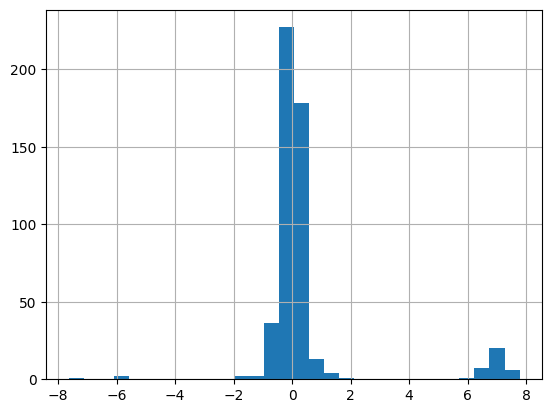

In [157]:
# Calculate the discrepancy between actual delivery fee and expected delivery fee
dirty_data['fee_discrepancy'] = dirty_data['delivery_fee'] - dirty_data['predicted_delivery_fee']

#Plot histogram for the fee discrepancy
dirty_data['fee_discrepancy'].hist(bins=30)
plt.show()

From the histogram, we can see that there are outliers. Which suggest that these outliers result from the wrong classification of loyalty.

In [158]:
dirty_data[(dirty_data['fee_discrepancy'].abs() > 2) & (dirty_data['fee_discrepancy'].abs() < 4)]

Empty DataFrame
Columns: [order_id, date, time, order_type, branch_code, order_items, order_price, customer_lat, customer_lon, customerHasloyalty?, distance_to_customer_KM, delivery_fee, is_weekend, time_of_day, predicted_delivery_fee, fee_discrepancy]
Index: []

In [159]:
# Display the rows with discrepancies for verification
discrepancies = dirty_data[dirty_data['fee_discrepancy'].abs() > 3]  # From the histogram, choose threshold = 3
discrepancies[['branch_code', 'distance_to_customer_KM', 'customerHasloyalty?', 'delivery_fee', 'predicted_delivery_fee', 'fee_discrepancy']].head(8)

branch_code  distance_to_customer_KM  customerHasloyalty?  delivery_fee  \
7            NS                   10.201                    0      7.427572   
31           TP                    9.856                    1     12.824670   
54           NS                    6.928                    1     12.911971   
55           TP                    8.964                    1     14.074983   
58           BK                   10.409                    1     18.896978   
98           BK                    8.528                    1     14.899156   
107          NS                    8.066                    1     14.088100   
110          NS                   10.336                    1     15.851624   

     predicted_delivery_fee  fee_discrepancy  
7                 15.071126        -7.643554  
31                 6.585242         6.239428  
54                 5.815766         7.096205  
55                 8.028018         6.046966  
58                11.740648         7.156330  
98                 7.358805         7.540350  
107                6.914379         7.173722  
110                9.105811         6.745813

We set the threshold to more than 2.1 because for records having discrpancy below 2.1, it seems like the discrepancies are caused by the model accuracy in prediction not because of the anomaly. <br>
<br>
Also, having a look at records that have fee discrepancy above the threshold, the predicted fee are either double or half the current delivery fee. This suggests the anomaly in the 'customerHasloyalty?' column. Hence, we changed the customer loyalty columns for these rows.

In [160]:
# Flip the customerHasloyalty? values for the rows with discrepancies
dirty_data.loc[discrepancies.index, 'customerHasloyalty?'] = dirty_data.loc[discrepancies.index, 'customerHasloyalty?'].apply(lambda x: 0 if x == 1 else 1)

In [161]:
combined_modified_rows = pd.concat([combined_modified_rows, dirty_data.loc[discrepancies.index]], ignore_index=True)
duplicates = combined_modified_rows[combined_modified_rows.duplicated(subset=['order_id'])]
# Again, check if any records have been updated twice
duplicates

Empty DataFrame
Columns: [order_id, date, time, order_type, branch_code, order_items, order_price, customer_lat, customer_lon, customerHasloyalty?, distance_to_customer_KM, delivery_fee, is_weekend, time_of_day, predicted_delivery_fee, fee_discrepancy]
Index: []

In [162]:
dirty_data.loc[discrepancies.index].shape

(37, 16)

In [163]:
combined_modified_rows.shape

(300, 16)

In [164]:
# Apply the training function on the dirty data after cleaning
d = train_branch_models(dirty_data)

Branch: TP, R2 Score: 0.98
Branch: NS, R2 Score: 0.98
Branch: BK, R2 Score: 0.95


Apply the training function on the whole dirty data and observe the result is pretty good.

After reformat the dirty data, fit the model on the whole dirty dataset and get R square value 0.98

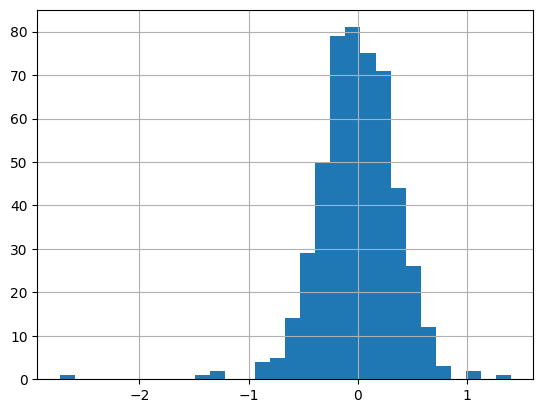

In [165]:
# Apply the prediction function to the dirty data
dirty_data['predicted_delivery_fee_new'] = dirty_data.apply(predict_delivery_fee, axis=1, models=d)

# Calculate the discrepancy between actual delivery fee and expected delivery fee
dirty_data['fee_discrepancynew'] = dirty_data['delivery_fee'] - dirty_data['predicted_delivery_fee_new']

#Plot histogram for the fee discrepancy
dirty_data['fee_discrepancynew'].hist(bins=30)
plt.show()

Apply the model to predict back the dirty data. Observe that the model can actually predict some of the delivery fee with none or really minimal difference. However, the value of large difference in predicted and actual value might be due to the present of outliers in the data.

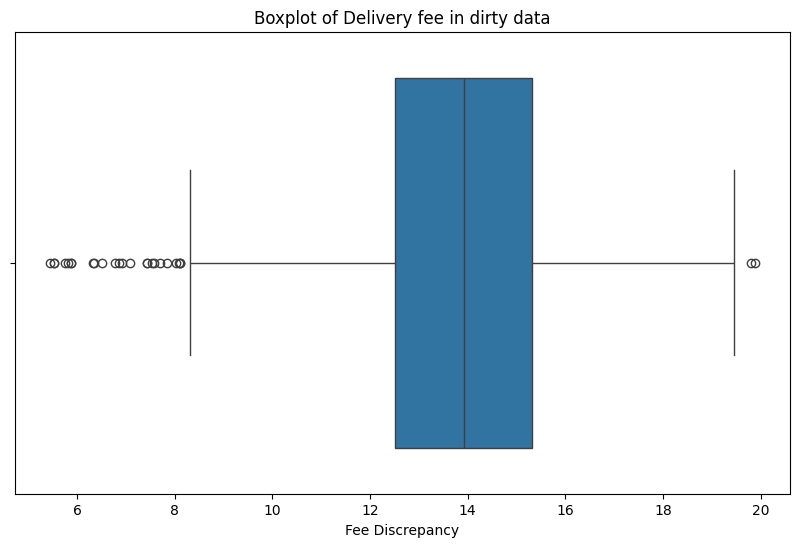

In [166]:
# Plot boxplot for fee_discrepancynew
plt.figure(figsize=(10, 6))
sns.boxplot(x=dirty_data['delivery_fee'])
plt.title('Boxplot of Delivery fee in dirty data')
plt.xlabel('Fee Discrepancy')
plt.show()

There are outliers but we decided to not remove them since the missing data can also have outliers. Also, the outliers can be valuable information since the distance from customers to the branch are not the same for every customer, so we decided that we will proceed with the current model/data without removing outliers.

## 2.3. Outliers data <a class="anchor" name="outlier"></a>

In [167]:
# Create feature for the outlier data
outliers['date'] = pd.to_datetime(outliers['date'])
outliers['is_weekend'] = outliers['date'].apply(get_weekday_or_weekend)

# Create a feature for time of the day
outliers['time'] = pd.to_datetime(outliers['time'], format='%H:%M:%S').dt.time
def classify_time(t):
    if time(8, 0) <= t <= time(12, 0):
        return 0
    elif time(12, 0, 1) <= t <= time(16, 0):
        return 1
    elif time(16, 0, 1) <= t <= time(20, 0):
        return 2
    return None
outliers['time_of_day'] = outliers['time'].apply(classify_time)

In [168]:
# Test current outliers dataset. It shows that the performance is not correct
train_branch_models(outliers)

Branch: NS, R2 Score: 0.80
Branch: TP, R2 Score: 0.80
Branch: BK, R2 Score: 0.73


{'NS': LinearRegression(), 'TP': LinearRegression(), 'BK': LinearRegression()}

Create boxplots and histogram for the delivery fee column

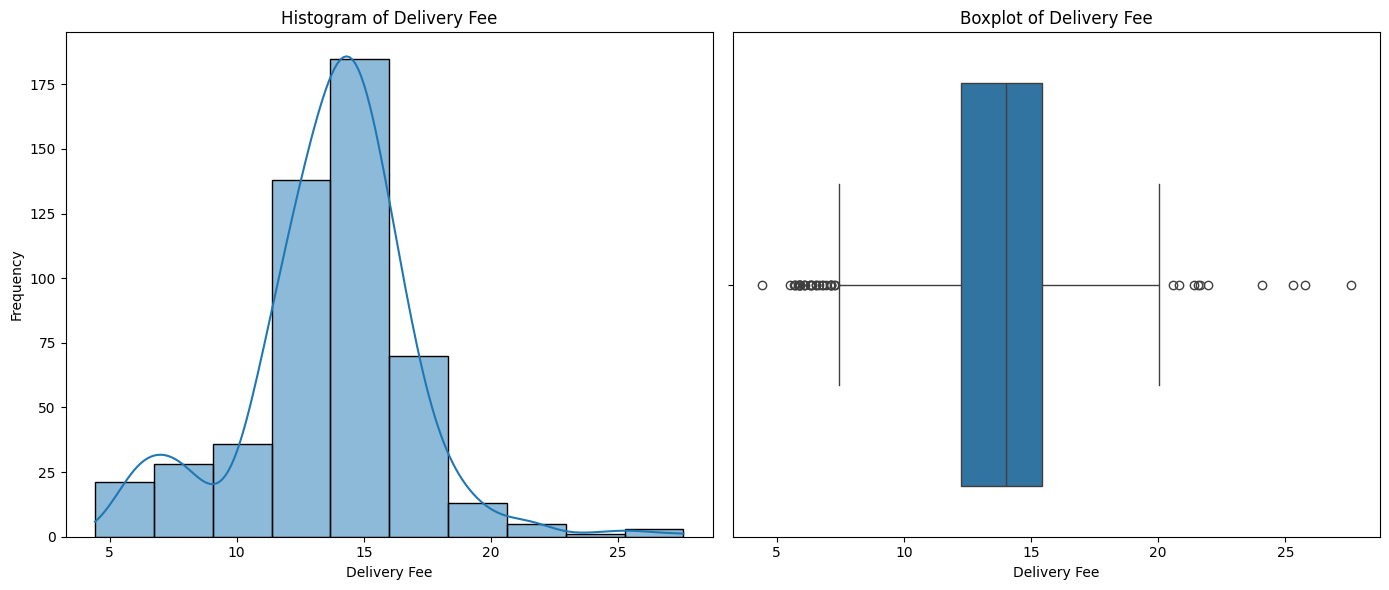

In [169]:
# Plot distribution using histogram and boxplot
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(outliers['delivery_fee'], bins=10, kde = True)
plt.title('Histogram of Delivery Fee')
plt.xlabel('Delivery Fee')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x = outliers['delivery_fee'])
plt.title('Boxplot of Delivery Fee')
plt.xlabel('Delivery Fee')

plt.tight_layout()
plt.show()

Use the model that has been trained on the clean data above (missing and dirty dataset) to predict the delivery fee for the outliers data, since the outliers only present in delivery fee column. Then we calculate the difference between the predicted fee and original fee.
<br>
<br>
We then set threshold to be 2 standard deviations from the prediction error and filter out erros greater than 2 threshold


In [170]:
# Predict the delivery fee for the missing data
outliers['predicted_delivery_fee'] = outliers.apply(predict_delivery_fee, axis=1, models = d)

# Calculate the prediction errors
outliers['prediction_error'] = outliers['delivery_fee'] - outliers['predicted_delivery_fee']

# Determine a threshold for outliers (errors greater than 2 standard deviations from the mean)
threshold = 2 * outliers['prediction_error'].std()

# Identify outliers
outliers['is_outlier'] = abs(outliers['prediction_error']) > threshold

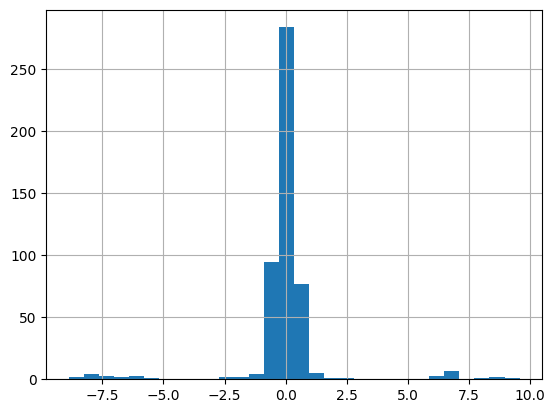

In [171]:
#Plot histogram for the fee discrepancy
outliers['prediction_error'].hist(bins=30)
plt.show()

In [172]:
# Display the outliers
outlier = outliers[outliers['is_outlier']]
outlier.head(10)

order_id       date      time order_type branch_code  \
5    ORDI05038 2018-03-09  10:11:49  Breakfast          NS   
6    ORDX06486 2018-10-10  17:17:44     Dinner          BK   
16   ORDI03358 2018-05-11  12:13:31      Lunch          NS   
26   ORDC09853 2018-12-13  19:29:34     Dinner          NS   
96   ORDC00219 2018-04-18  11:32:57  Breakfast          NS   
98   ORDC04047 2018-09-10  16:16:54     Dinner          NS   
113  ORDI09010 2018-04-18  11:32:57  Breakfast          NS   
117  ORDY07507 2018-05-10  12:13:31      Lunch          TP   
128  ORDA03829 2018-10-03  17:07:36     Dinner          BK   
162  ORDX01339 2018-03-15  10:21:58  Breakfast          BK   

                                           order_items  order_price  \
5    [(Coffee, 7), (Cereal, 8), (Pancake, 8), (Eggs...       436.50   
6                       [(Shrimp, 9), (Fish&Chips, 4)]       626.00   
16                            [(Fries, 1), (Salad, 4)]        80.80   
26                      [(Fish&Chips, 7), (Salmon, 9)]       614.00   
96                            [(Eggs, 5), (Cereal, 4)]       194.00   
98         [(Salmon, 3), (Shrimp, 8), (Fish&Chips, 7)]       800.00   
113              [(Cereal, 3), (Coffee, 4), (Eggs, 3)]       159.00   
117                          [(Burger, 1), (Fries, 2)]        55.00   
128  [(Shrimp, 2), (Pasta, 7), (Salmon, 8), (Fish&C...       908.50   
162  [(Cereal, 8), (Eggs, 8), (Coffee, 7), (Pancake...       614.75   

     customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
5      -37.808701    144.972956                    0                    7.173   
6      -37.812482    144.953347                    0                    8.494   
16     -37.826287    144.952088                    0                   10.165   
26     -37.816166    144.975278                    0                   10.768   
96     -37.799616    144.963654                    0                    6.825   
98     -37.816200    144.964091                    0                    8.271   
113    -37.816142    144.972410                    0                    7.913   
117    -37.800371    144.963878                    0                    9.713   
128    -37.802477    144.963315                    0                    7.820   
162    -37.820421    144.985002                    0                    6.360   

     delivery_fee  is_weekend  time_of_day  predicted_delivery_fee  \
5        6.068356           0            0               12.146275   
6        7.859133           0            2               15.493263   
16       7.822724           0            1               15.636468   
26      25.307396           0            2               16.776194   
96       5.705750           0            0               11.803888   
98      21.414321           0            2               14.319469   
113     19.863072           0            0               12.874339   
117     19.132677           0            1               13.047956   
128      7.661548           0            2               14.783251   
162      5.905831           0            0               11.216321   

     prediction_error  is_outlier  
5           -6.077919        True  
6           -7.634130        True  
16          -7.813744        True  
26           8.531202        True  
96          -6.098137        True  
98           7.094853        True  
113          6.988733        True  
117          6.084721        True  
128         -7.121704        True  
162         -5.310490        True

In [173]:
outlier.shape
#29 rows of outliers

(29, 17)

In [174]:
new_outliers = outliers[~outliers['is_outlier']]

In [175]:
train_branch_models(new_outliers)

Branch: NS, R2 Score: 0.97
Branch: TP, R2 Score: 0.98
Branch: BK, R2 Score: 0.97


{'NS': LinearRegression(), 'TP': LinearRegression(), 'BK': LinearRegression()}

## 2.4. Missing data <a class="anchor" name="missing"></a>

In [176]:
# Create feature for the missing data
missing_data['date'] = pd.to_datetime(missing_data['date'])
missing_data['is_weekend'] = missing_data['date'].apply(get_weekday_or_weekend)

# Create a feature for time of the day
missing_data['time'] = pd.to_datetime(missing_data['time'], format='%H:%M:%S').dt.time
def classify_time(t):
    if time(8, 0) <= t <= time(12, 0):
        return 0
    elif time(12, 0, 1) <= t <= time(16, 0):
        return 1
    elif time(16, 0, 1) <= t <= time(20, 0):
        return 2
    return None
missing_data['time_of_day'] = missing_data['time'].apply(classify_time)

In [177]:
# Count missing values in each column
missing_data.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                100
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM     50
delivery_fee                50
is_weekend                   0
time_of_day                  0
dtype: int64

In [178]:
missing_data.head()

order_id       date      time order_type branch_code  \
0  ORDX09691 2018-08-14  15:26:11      Lunch          BK   
1  ORDC02242 2018-10-23  17:48:10     Dinner          NS   
2  ORDC04615 2018-08-06  15:05:54      Lunch          NS   
3  ORDY01427 2018-08-07  15:16:03      Lunch          TP   
4  ORDK03465 2018-11-01  18:08:27     Dinner          BK   

                                         order_items  order_price  \
0                     [('Chicken', 7), ('Steak', 2)]        314.0   
1  [('Salmon', 4), ('Pasta', 3), ('Shrimp', 9), (...       1082.5   
2  [('Burger', 4), ('Steak', 8), ('Fries', 1), ('...        833.2   
3  [('Chicken', 5), ('Steak', 10), ('Salad', 9), ...        836.8   
4  [('Pasta', 4), ('Fish&Chips', 7), ('Salmon', 4...        789.0   

   customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
0    -37.823000    144.964487                    0                    8.263   
1    -37.808386    144.947741                    0                    8.839   
2    -37.811974    144.986043                    0                    8.461   
3    -37.811963    144.955816                    0                    8.700   
4    -37.824024    144.981934                    0                    6.978   

   delivery_fee  is_weekend  time_of_day  
0     13.625409           0            1  
1     14.986691           0            2  
2     14.023621           0            1  
3           NaN           0            1  
4     13.534581           0            2

In [179]:
# Identify rows with missing branch_code but present distance_to_customer_KM
missing_branch_only = missing_data[missing_data['branch_code'].isna() & missing_data['distance_to_customer_KM'].notna() & missing_data['delivery_fee'].notna()]
missing_branch_only.head()

order_id       date      time order_type branch_code  \
9   ORDJ03493 2018-08-21  15:36:20      Lunch         NaN   
17  ORDZ04006 2018-06-14  13:24:30      Lunch         NaN   
22  ORDX08096 2018-05-22  12:33:48      Lunch         NaN   
39  ORDY04481 2018-09-14  16:27:02     Dinner         NaN   
44  ORDA08588 2018-11-20  18:38:52     Dinner         NaN   

                                          order_items  order_price  \
9   [('Burger', 7), ('Salad', 1), ('Steak', 2), ('...        612.2   
17       [('Fries', 2), ('Burger', 10), ('Steak', 9)]        739.0   
22                       [('Salad', 6), ('Steak', 5)]        328.2   
39  [('Fish&Chips', 5), ('Shrimp', 4), ('Salmon', 9)]        760.0   
44                      [('Pasta', 5), ('Salmon', 3)]        260.5   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
9     -37.823674    144.990380                    0                    9.438   
17    -37.809527    144.963824                    0                    7.405   
22    -37.805102    144.949222                    0                    8.670   
39    -37.815129    144.935255                    0                   10.624   
44    -37.825243    145.016573                    0                    5.007   

    delivery_fee  is_weekend  time_of_day  
9      13.238887           0            1  
17     13.194163           0            1  
22     15.068228           0            1  
39     14.390147           0            2  
44     12.085843           0            2

In [180]:
# Identify rows with missing distance_to_customer_KM but present branch_code
missing_distance_only = missing_data[missing_data['branch_code'].notna() & missing_data['distance_to_customer_KM'].isna()]
missing_distance_only

Empty DataFrame
Columns: [order_id, date, time, order_type, branch_code, order_items, order_price, customer_lat, customer_lon, customerHasloyalty?, distance_to_customer_KM, delivery_fee, is_weekend, time_of_day]
Index: []

In [181]:
missing_both = missing_data[missing_data['branch_code'].isna() & missing_data['distance_to_customer_KM'].isna() & missing_data['delivery_fee'].notna()]
missing_both.head()

order_id       date      time order_type branch_code  \
15  ORDY04281 2018-04-04  11:02:32  Breakfast         NaN   
40  ORDY02591 2018-10-21  17:38:01     Dinner         NaN   
46  ORDZ10690 2018-02-12  09:21:07  Breakfast         NaN   
58  ORDB03858 2018-03-17  10:21:58  Breakfast         NaN   
79  ORDZ04450 2018-04-12  11:22:49  Breakfast         NaN   

                                          order_items  order_price  \
15     [('Pancake', 1), ('Coffee', 4), ('Cereal', 3)]       117.25   
40                     [('Pasta', 6), ('Salmon', 10)]       575.00   
46                      [('Pancake', 8), ('Eggs', 9)]       392.00   
58                    [('Coffee', 10), ('Cereal', 7)]       222.00   
79  [('Eggs', 10), ('Coffee', 7), ('Pancake', 10),...       662.00   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
15    -37.805403    144.973648                    0                      NaN   
40    -37.821413    144.969275                    0                      NaN   
46    -37.815651    144.974111                    0                      NaN   
58    -37.807566    144.942401                    0                      NaN   
79    -37.813503    144.961790                    0                      NaN   

    delivery_fee  is_weekend  time_of_day  
15     11.403456           0            0  
40     13.781046           1            2  
46     13.090536           0            0  
58     14.351058           1            0  
79     12.837511           0            0

In [182]:
missing_branch_only.shape

(50, 14)

In [183]:
missing_both.shape

(50, 14)

According to the above analysis on the missing data and identify that there are 2 cases:


1.   Missing branch_code but have the distance
2.   Missing both branch_code and distance

Also, we verified that within these missing rows, the delivery fee is present. Hence, we will approach these in 2 different ways for better prediction in the missing delivery fee.



### 2.4.1. Missing branch code but have distance <a class="anchor" name="m1"></a>

In [184]:
# Apply the function to infer missing branch_code and print distances
for index, row in missing_branch_only.iterrows():
    customer_lat = row["customer_lat"]
    customer_lon = row["customer_lon"]
    given_distance = row["distance_to_customer_KM"]

    distances = find_nearest_branch(customer_lat, customer_lon, nodes, branch, G)

    # Find the branch whose calculated distance is closest to the given distance
    nearest_branch = min(distances, key=lambda k: abs(distances[k] - given_distance))
    correct_distance = distances[nearest_branch]

    # Update the missing branch_code
    missing_branch_only.at[index, "correct_branch"] = nearest_branch
    missing_branch_only.at[index, "distance_to_correct_branch"] = correct_distance

In [185]:
missing_branch_only.head(10)

order_id       date      time order_type branch_code  \
9   ORDJ03493 2018-08-21  15:36:20      Lunch         NaN   
17  ORDZ04006 2018-06-14  13:24:30      Lunch         NaN   
22  ORDX08096 2018-05-22  12:33:48      Lunch         NaN   
39  ORDY04481 2018-09-14  16:27:02     Dinner         NaN   
44  ORDA08588 2018-11-20  18:38:52     Dinner         NaN   
49  ORDA00371 2018-10-17  17:38:01     Dinner         NaN   
51  ORDY07009 2018-12-09  19:19:26     Dinner         NaN   
52  ORDC07463 2018-05-31  12:54:05      Lunch         NaN   
62  ORDX06383 2018-04-24  11:43:05  Breakfast         NaN   
64  ORDC03608 2018-10-06  17:07:36     Dinner         NaN   

                                          order_items  order_price  \
9   [('Burger', 7), ('Salad', 1), ('Steak', 2), ('...        612.2   
17       [('Fries', 2), ('Burger', 10), ('Steak', 9)]        739.0   
22                       [('Salad', 6), ('Steak', 5)]        328.2   
39  [('Fish&Chips', 5), ('Shrimp', 4), ('Salmon', 9)]        760.0   
44                      [('Pasta', 5), ('Salmon', 3)]        260.5   
49                [('Fish&Chips', 10), ('Shrimp', 8)]        782.0   
51  [('Pasta', 3), ('Fish&Chips', 1), ('Salmon', 7...        782.5   
52  [('Salad', 7), ('Fries', 3), ('Steak', 5), ('B...        567.4   
62        [('Coffee', 9), ('Eggs', 4), ('Cereal', 5)]        260.5   
64   [('Shrimp', 8), ('Pasta', 2), ('Fish&Chips', 1)]        522.0   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
9     -37.823674    144.990380                    0                    9.438   
17    -37.809527    144.963824                    0                    7.405   
22    -37.805102    144.949222                    0                    8.670   
39    -37.815129    144.935255                    0                   10.624   
44    -37.825243    145.016573                    0                    5.007   
49    -37.814971    144.975139                    0                    6.704   
51    -37.817529    144.995960                    0                   10.290   
52    -37.820291    144.957697                    0                    9.173   
62    -37.818072    144.970910                    0                    7.341   
64    -37.824377    144.982489                    0                    9.319   

    delivery_fee  is_weekend  time_of_day correct_branch  \
9      13.238887           0            1             TP   
17     13.194163           0            1             NS   
22     15.068228           0            1             BK   
39     14.390147           0            2             TP   
44     12.085843           0            2             BK   
49     12.863739           0            2             BK   
51     16.292688           1            2             TP   
52     14.614339           0            1             NS   
62     12.292329           0            0             BK   
64     17.548705           1            2             NS   

    distance_to_correct_branch  
9                        9.438  
17                       7.405  
22                       8.670  
39                      10.624  
44                       5.007  
49                       6.704  
51                      10.290  
52                       9.173  
62                       7.341  
64                       9.319

Verify by calculate the distance to this branch and observe it matches with the given distance

In [186]:
#Update these branch in missing data
for index, row in missing_branch_only.iterrows():
    missing_data.at[index, "branch_code"] = row["correct_branch"]

### 2.4.2. Missing branch code and distance <a class="anchor" name="m2"></a>

In [187]:
# The function will calculate the shortest distance from customers to all three branches.
# Then use these to predict the delivery fee for all three branches.
# The correct identified branch is the one with closest predicted delivery fee to original delivery fee

def predict_delivery_fee_for_branches(row, models, branches_df, nodes_df, G):
    customer_lat = row["customer_lat"]
    customer_lon = row["customer_lon"]
    observed_fee = row["delivery_fee"]

    closest_customer_node = find_closest_node_kdtree(customer_lat, customer_lon, nodes_df, kdtree)

    predicted_fees = {}
    for branch_code in branches_df['branch_code'].unique():
        branch_row = branches_df[branches_df['branch_code'] == branch_code].iloc[0]
        branch_lat = branch_row['branch_lat']
        branch_lon = branch_row['branch_lon']

        closest_branch_node = find_closest_node_kdtree(branch_lat, branch_lon, nodes_df, kdtree)

        if closest_customer_node and closest_branch_node:
            try:
                distance = nx.dijkstra_path_length(G, closest_customer_node, closest_branch_node) / 1000
                row['distance_to_customer_KM'] = distance
                model = models.get(branch_code)
                if model is not None:
                    X = np.array([[row['is_weekend'], row['time_of_day'], distance, row['customerHasloyalty?']]])
                    fee = model.predict(X)[0]
                    predicted_fees[branch_code] = fee
            except nx.NetworkXNoPath:
                continue

    if predicted_fees:
        best_branch = min(predicted_fees, key=lambda k: abs(predicted_fees[k] - observed_fee))
        best_distance = nx.dijkstra_path_length(G, closest_customer_node, find_closest_node_kdtree(
            branches_df[branches_df['branch_code'] == best_branch]['branch_lat'].values[0],
            branches_df[branches_df['branch_code'] == best_branch]['branch_lon'].values[0], nodes_df, kdtree)) / 1000
        best_fee = predicted_fees[best_branch]
        return best_branch, best_distance, best_fee
    else:
        return np.nan, np.nan, np.nan


In [188]:
combined = pd.concat([dirty_data, new_outliers])
new_model = train_branch_models(combined)

Branch: TP, R2 Score: 0.98
Branch: NS, R2 Score: 0.97
Branch: BK, R2 Score: 0.97


In [189]:
for index, row in missing_both.iterrows():
    best_branch, best_distance, best_fee = predict_delivery_fee_for_branches(row, new_model, branch, nodes, G)
    missing_both.at[index, "predicted_branch_code"] = best_branch
    missing_both.at[index, "predicted_distance_to_customer_KM"] = best_distance
    missing_both.at[index, "predicted_delivery_fee"] = best_fee

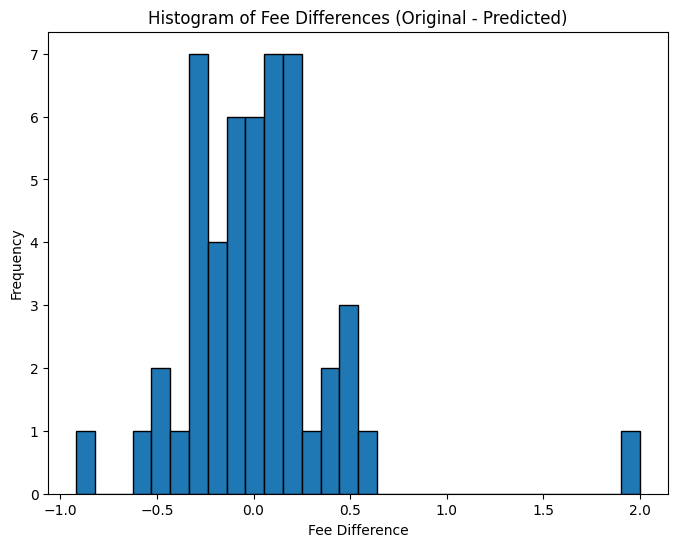

In [190]:
missing_both['fee_difference'] = missing_both['delivery_fee'] - missing_both['predicted_delivery_fee']

plt.figure(figsize=(8, 6))
plt.hist(missing_both['fee_difference'], bins=30, edgecolor='k')
plt.xlabel('Fee Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Fee Differences (Original - Predicted)')
plt.show()

The predicted delivery fee is pretty close to the delivery fee

In [191]:
# Impute missing branch code and distance
for index, row in missing_both.iterrows():
    missing_data.at[index, "branch_code"] = row["predicted_branch_code"]
    missing_data.at[index, "distance_to_customer_KM"] = row["predicted_distance_to_customer_KM"]

In [192]:
missing_data.isnull().sum()

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM     0
delivery_fee               50
is_weekend                  0
time_of_day                 0
dtype: int64

#### Use clean rows (non NAs rows in missing data and dirty data) to predict the delivery fee

In [193]:
updated_non_missing_data = missing_data.dropna()

In [194]:
updated_combined_data = pd.concat([updated_non_missing_data, dirty_data, new_outliers])
new_branch_models = train_branch_models(updated_combined_data)

Branch: BK, R2 Score: 0.97
Branch: NS, R2 Score: 0.98
Branch: TP, R2 Score: 0.97


In [195]:
# Apply the prediction function to the missing delivery_fee rows
missing_data_na_fee = missing_data[missing_data['delivery_fee'].isna()]

missing_data_na_fee['predicted_delivery_fee'] = missing_data_na_fee.apply(predict_delivery_fee, axis=1, models = new_branch_models)

# Update the missing_data DataFrame with the predicted delivery_fee
for index, row in missing_data_na_fee.iterrows():
    missing_data.at[index, 'delivery_fee'] = row['predicted_delivery_fee']

In [196]:
# Update the missing delivery_fee values with predicted values
missing_data['delivery_fee'].fillna(missing_data_na_fee['predicted_delivery_fee'], inplace=True)

In [197]:
missing_data.isna().sum()

order_id                   0
date                       0
time                       0
order_type                 0
branch_code                0
order_items                0
order_price                0
customer_lat               0
customer_lon               0
customerHasloyalty?        0
distance_to_customer_KM    0
delivery_fee               0
is_weekend                 0
time_of_day                0
dtype: int64

In [198]:
train_branch_models(missing_data)

Branch: BK, R2 Score: 0.99
Branch: NS, R2 Score: 0.97
Branch: TP, R2 Score: 0.97


{'BK': LinearRegression(), 'NS': LinearRegression(), 'TP': LinearRegression()}

Use the model that used to predict missing value to try on the combined dataset.

In [199]:
# Apply the prediction function to the DataFrame
updated_combined_data['predicted_delivery_fee'] = updated_combined_data.apply(predict_delivery_fee, axis=1, models=new_branch_models)

# Calculate the difference between the original delivery fee and the predicted delivery fee
updated_combined_data['fee_difference'] = updated_combined_data['delivery_fee'] - updated_combined_data['predicted_delivery_fee']

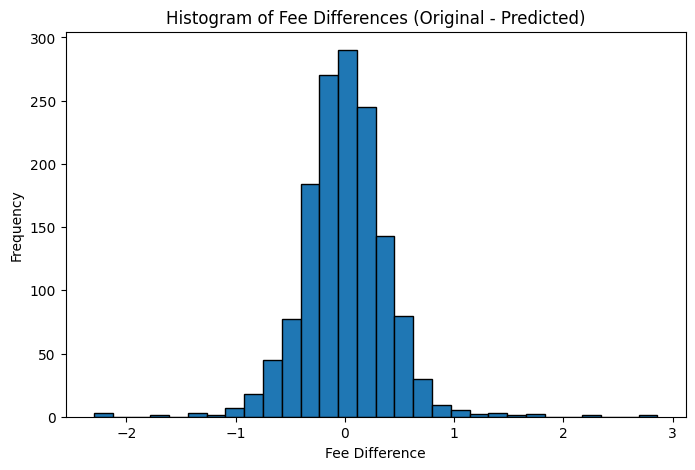

In [200]:
plt.figure(figsize=(8, 5))
plt.hist(updated_combined_data['fee_difference'], bins=30, edgecolor='k')
plt.xlabel('Fee Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Fee Differences (Original - Predicted)')
plt.show()

From the histogram, we can see that the difference in actuall delivery fee follows a normal distribution, where for most of the records, the differences are really small (between -1 and 1). For the large differences, it might be due to the present of outliers. Also, with an R squared value of 0.99, 0.97, 0.97 for three branches when predicting the whole missing dataset. We think it is good enough.

Testing on all three dataset

In [201]:
final = pd.concat([missing_data, dirty_data, new_outliers])
m = train_branch_models(final)

Branch: BK, R2 Score: 0.97
Branch: NS, R2 Score: 0.97
Branch: TP, R2 Score: 0.97


## 2.5. Generating output files <a class="anchor" name="output"></a>

In [202]:
dirty_data.drop(columns = ['is_weekend', 'time_of_day', 'predicted_delivery_fee', 'fee_discrepancy', 'predicted_delivery_fee_new', 'fee_discrepancynew'], inplace=True)
missing_data.drop(columns = ['is_weekend', 'time_of_day'], inplace=True)
new_outliers.drop(columns = ['is_weekend', 'time_of_day', 'predicted_delivery_fee', 'prediction_error', 'is_outlier'], inplace=True)

In [203]:
#Round the order price to 1 decimal place
dirty_data['order_price'] = dirty_data['order_price'].apply(lambda x: round(x, 1))

In [204]:
# Save DataFrames to CSV files
dirty_data.to_csv('/content/drive/MyDrive/submit/Group068_dirty_data_solution.csv', index=False)
new_outliers.to_csv('/content/drive/MyDrive/submit/Group068_outlier_data_solution.csv', index=False)
missing_data.to_csv('/content/drive/MyDrive/submit/Group068_missing_data_solution.csv', index=False)

# 3. Task 2 - Data Reshaping <a class="anchor" name="task2"></a>

In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

In [206]:
data = pd.read_excel("/content/drive/Shareddrives/FIT5196_S1_2024/A2/supplementary_data/suburb_info.xlsx")

In [207]:
data.head()

suburb  number_of_houses  number_of_units   municipality aus_born_perc  \
0  ABBOTSFORD              2304             4706          Yarra           68%   
1  ABERFELDIE              1410              453  Moonee Valley           81%   
2   ALBANVALE              1897              138       Brimbank           46%   
3      ALBION              1389             1392       Brimbank           52%   
4  ALPHINGTON              1729             1099        Darebin           73%   

  median_income median_house_price  population  
0        $1,797         $1,299,400        4025  
1        $1,571         $1,926,600       22442  
2          $907           $594,200       54005  
3          $929           $739,100       30677  
4        $1,538         $1,729,600        9227

In [208]:
# Data process

# Cleaning the aus_born_perc column
data['aus_born_perc'] = data['aus_born_perc'].replace('%', '', regex=True).astype(float)

# Cleaning and converting median_income and median_house_price columns
data['median_income'] = data['median_income'].replace('[\$,]', '', regex=True).astype(float)
data['median_house_price'] = data['median_house_price'].replace('[\$,]', '', regex=True).astype(float)

## 3.1. Initial Data Analysis <a class="anchor" name="da"></a>

Create histograms for each feature to understand their distributions.

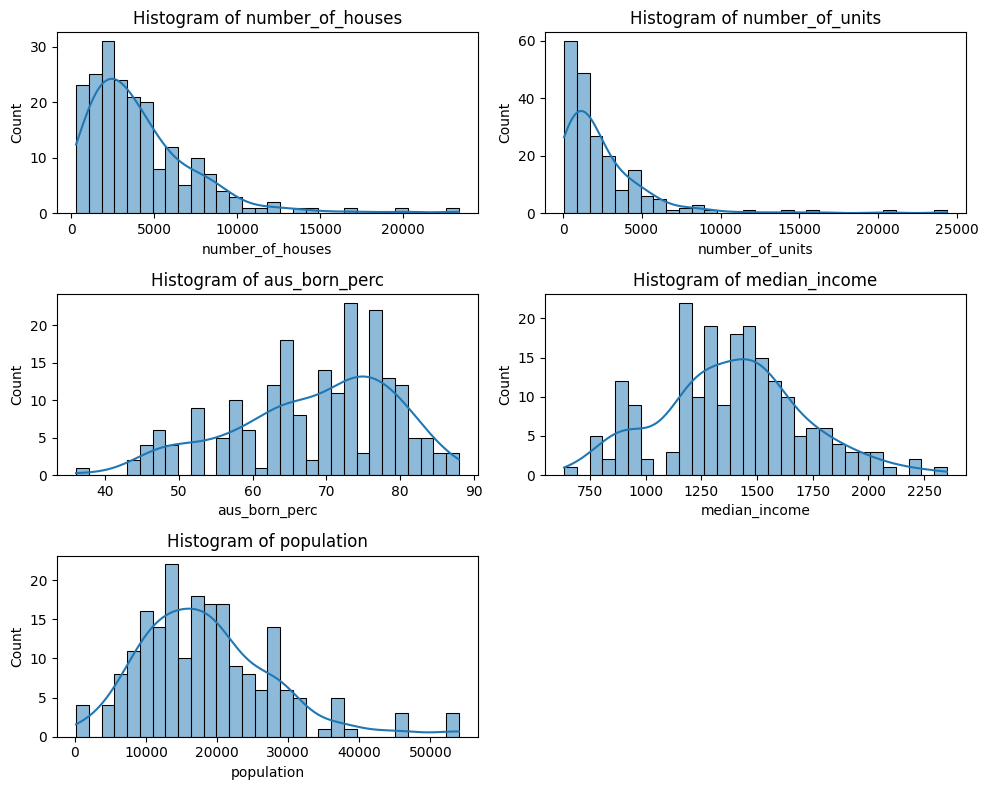

In [209]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot histograms for each feature
features = ['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'population']
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()


The histograms for each variable indicate that the majority of them do not follow a normal distribution.



1.   number_of_houses: Appears to be right-skewed with a few suburbs having a significantly higher number of houses
2.   number_of_units: Also right-skewed, indicating a few suburbs have a high number of units.
3. aus_born_perc: Distribution is slightly left-skewed
4. median_income: Slightly normal distribution
5. population: Right-skewed, with some suburbs having a very high population, indicating outliers.





Then, we’ll examine whether there’s a linear relationship between each independent variable and the dependent variable median_house_price by plotting scatter plots.

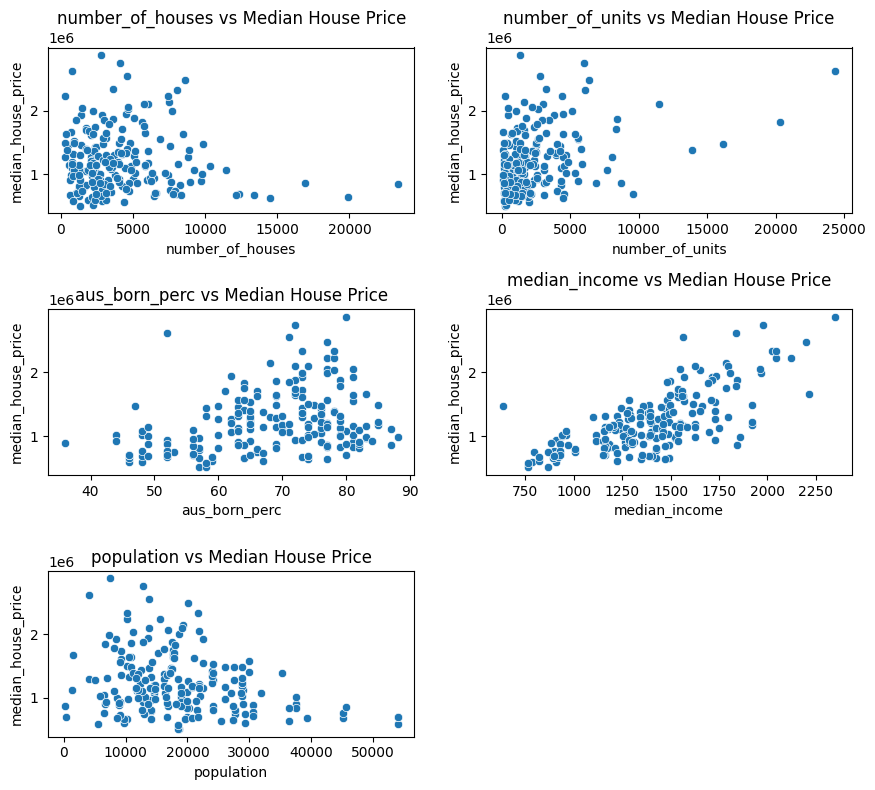

In [210]:
# Set up the matplotlib figure
plt.figure(figsize=(9, 8))

# Plot scatter plots for each feature against the target variable
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=data[feature], y=data['median_house_price'])
    plt.title(f'{feature} vs Median House Price')

plt.tight_layout()
plt.show()

From the above scatter plots:


1.   number_of_houses has weak positive correlation with median_house_price
2.   number_of_units has weak positive correlation with median_house_price
3. aus_born_perc: Slight positive correlation with median_house_price
4.median_income: Strong positive correlation with median_house_price
5. population: Weak correlation with median_house_price



The scatter plots reveal that, except for the relationship between `median_income` and `median_house_price`, which appears to be linearly correlated, the relationships between the other independent variables and the dependent variable are not evidently linear. Hence, transformations are required for these variables.

## 3.2. Data Transformation <a class="anchor" name="dt"></a>

Apply all 5 transformation types on the data to observe how each of the transformation affects the relationship/correlation between that variable and median house price


### 3.2.1. Standardization <a class="anchor" name="s"></a>

In [211]:
# Standardization
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income']])
data_standardized = pd.DataFrame(data_standardized, columns=['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income'])

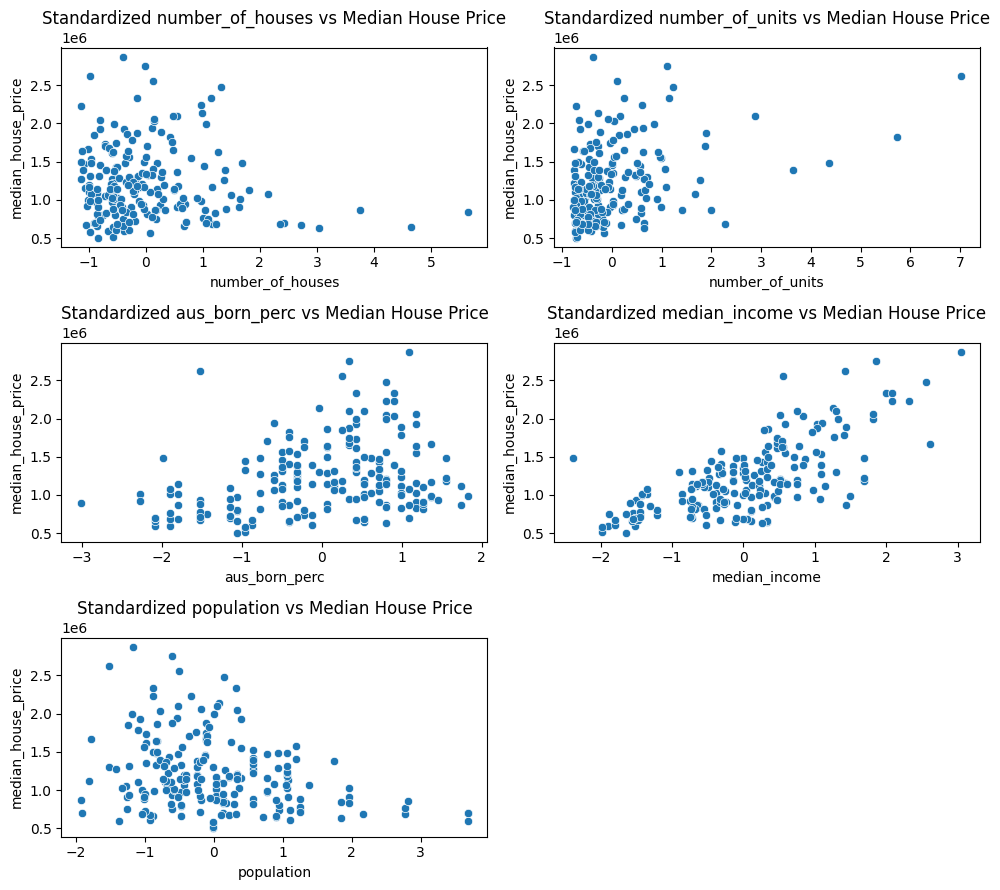

In [212]:
# Plot scatter plots for standardized features against median_house_price
plt.figure(figsize=(10, 9))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x = data_standardized[feature], y = data['median_house_price'])
    plt.title(f'Standardized {feature} vs Median House Price')
plt.tight_layout()
plt.show()

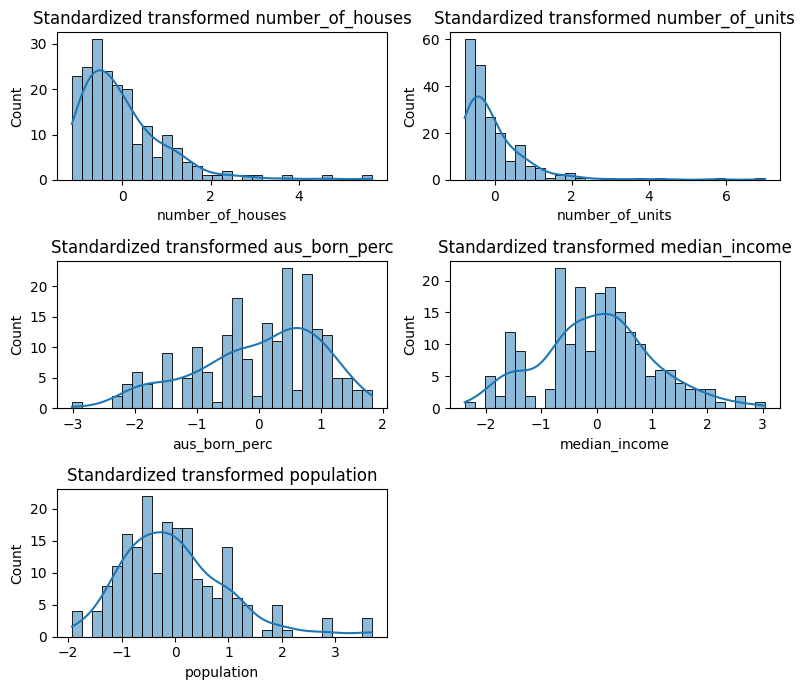

In [213]:
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data_standardized[feature], bins=30, kde=True)
    plt.title(f'Standardized transformed {feature}')
plt.tight_layout()
plt.show()


The features are now centered around 0 with a standard deviation of 1. The linear relationships with median_house_price appear more pronounced for some features like median_income.

### 3.2.2. Min-Max Scaling <a class="anchor" name="m"></a>

In [214]:
min_max_scaler = MinMaxScaler()
data_min_max = min_max_scaler.fit_transform(data[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income']])
data_min_max = pd.DataFrame(data_min_max, columns=['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income'])

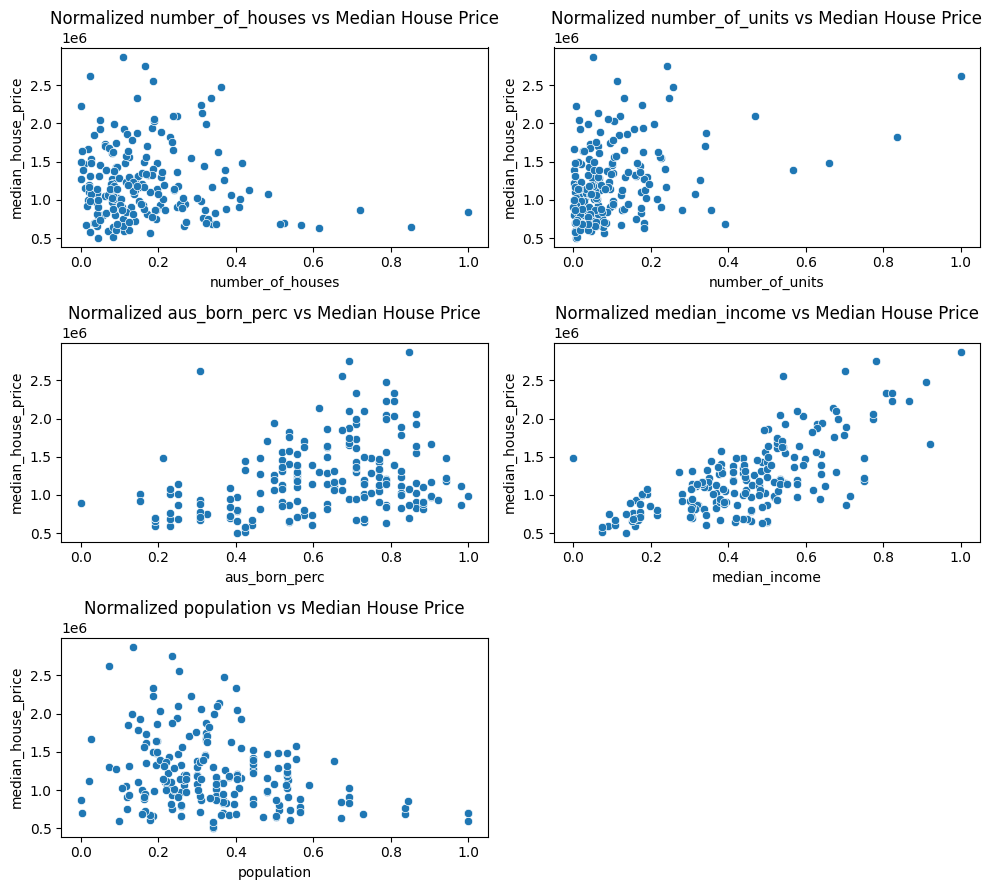

In [215]:
# Plot scatter plots for normalized features against median_house_price
plt.figure(figsize=(10, 9))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x = data_min_max[feature], y = data['median_house_price'])
    plt.title(f'Normalized {feature} vs Median House Price')
plt.tight_layout()
plt.show()

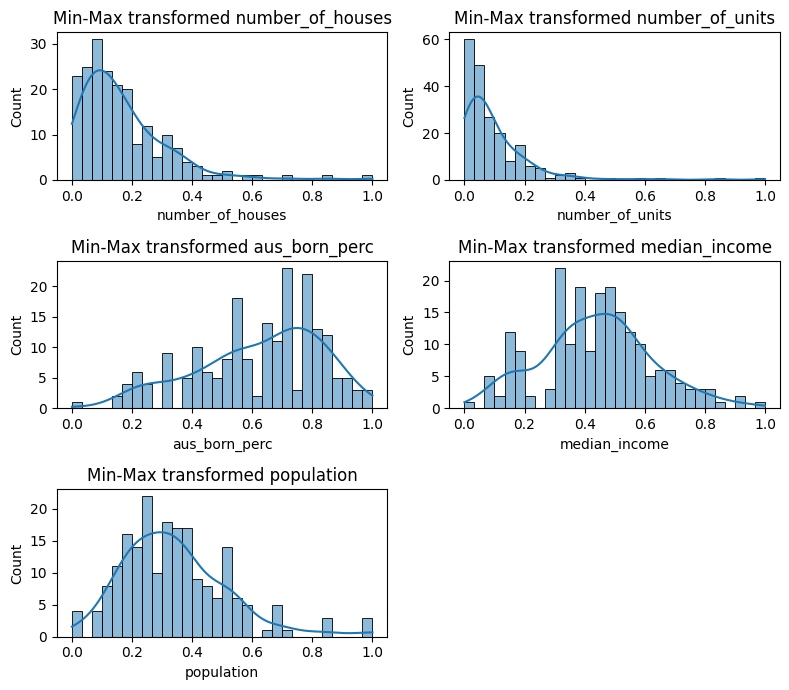

In [216]:
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data_min_max[feature], bins=30, kde=True)
    plt.title(f'Min-Max transformed {feature}')
plt.tight_layout()
plt.show()

The features are now scaled between 0 and 1. The linear relationships with median_house_price appear similar to the original data but scaled down.


### 3.2.3. Log Transformation <a class="anchor" name="l"></a>

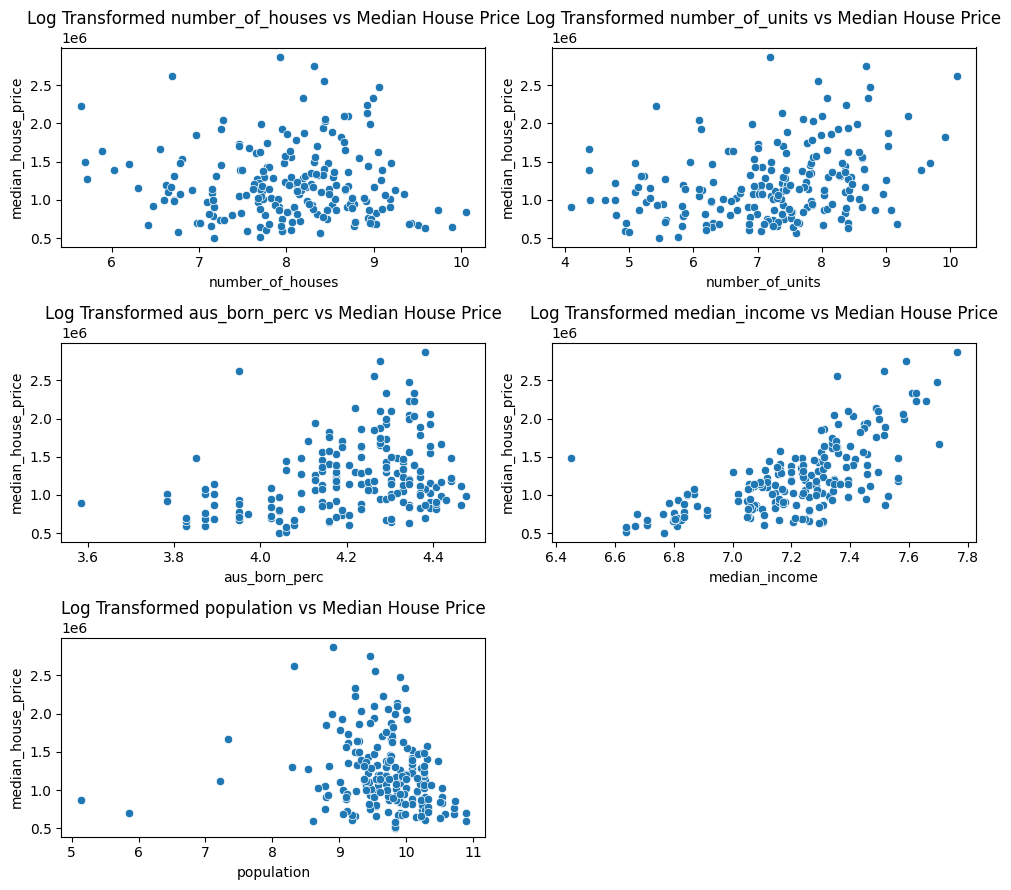

In [217]:
# Log Transformation: Add a small constant to avoid log(0)
data_log = np.log(data[['number_of_houses', 'number_of_units','aus_born_perc','population', 'median_income']] + 1e-9)

# Plot scatter plots for log-transformed features against median_house_price
plt.figure(figsize=(10, 9))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x = data_log[feature], y = data['median_house_price'])
    plt.title(f'Log Transformed {feature} vs Median House Price')
plt.tight_layout()
plt.show()

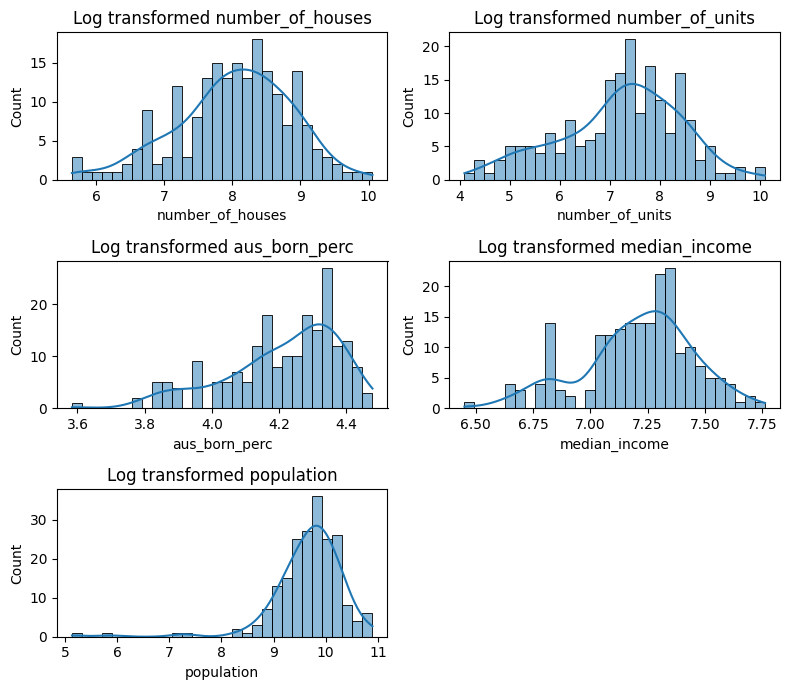

In [218]:
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data_log[feature], bins=30, kde=True)
    plt.title(f'Log transformed {feature}')
plt.tight_layout()
plt.show()

The transformed features show improved linear relationships with median_house_price, especially for number_of_houses and number_of_units

### 3.2.4. Box-Cox Transformation <a class="anchor" name="b"></a>

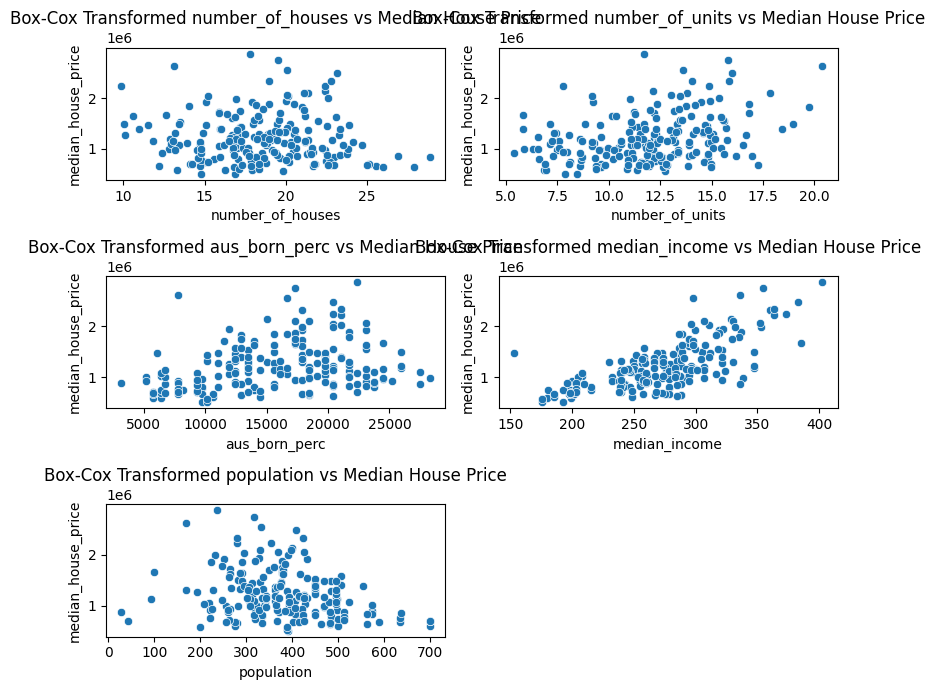

In [219]:
data_boxcox = pd.DataFrame()
for column in ['number_of_houses', 'number_of_units','aus_born_perc', 'population', 'median_income']:
    fitted_data, _ = boxcox(data[column]+1)  # adding 1 to handle zero values if present
    data_boxcox[column] = fitted_data

# Plot scatter plots for Box-Cox transformed features against median_house_price
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x = data_boxcox[feature], y = data['median_house_price'])
    plt.title(f'Box-Cox Transformed {feature} vs Median House Price')
plt.tight_layout()
plt.show()

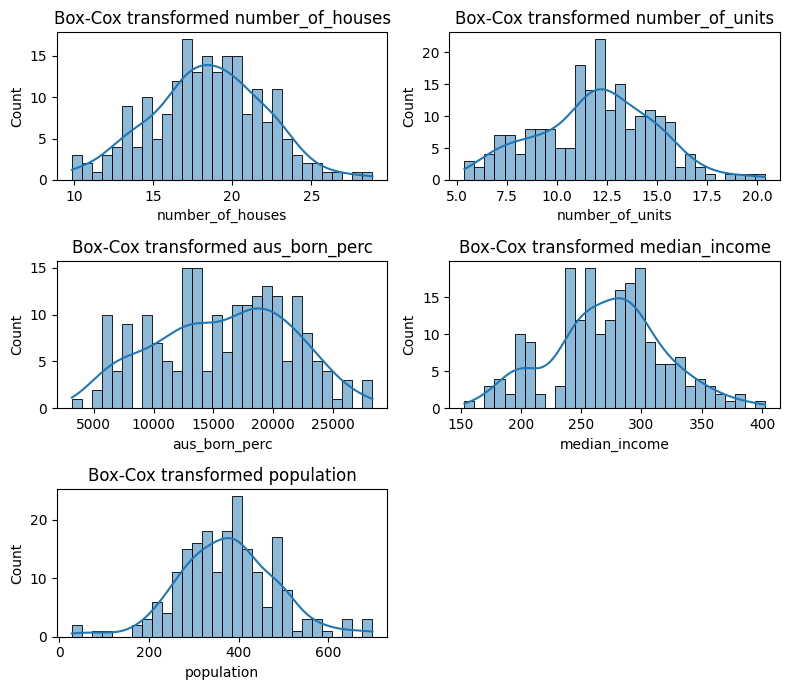

In [220]:
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data_boxcox[feature], bins=30, kde=True)
    plt.title(f'Box-Cox transformed {feature}')
plt.tight_layout()
plt.show()

The features show improved linear relationships, but the transformation is only applied to strictly positive values.

### 3.2.5. Power Transformation <a class="anchor" name="p"></a>

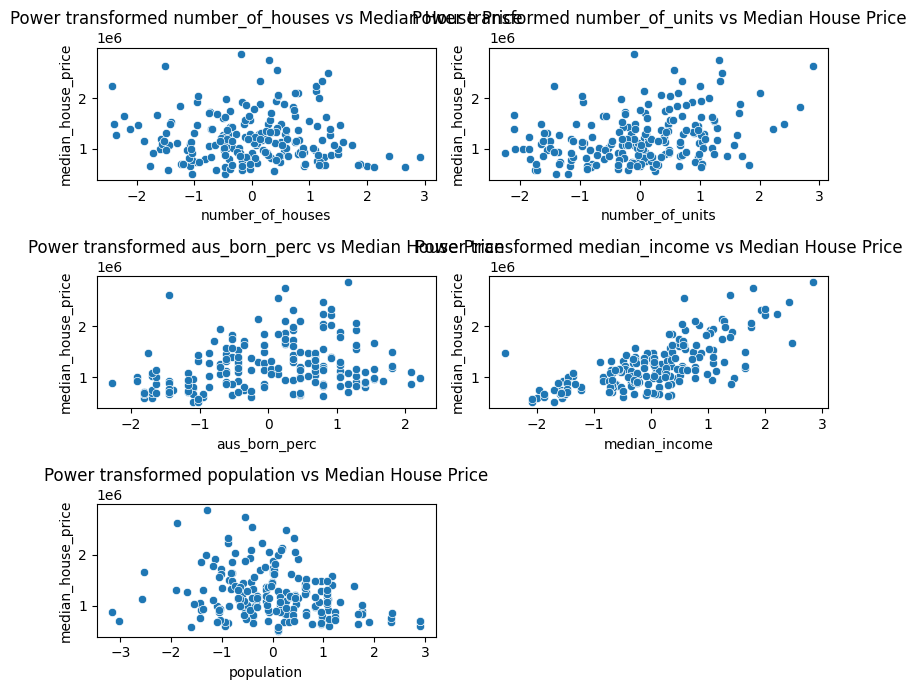

In [221]:
# Power Transformation
power_transformer = PowerTransformer(method = 'yeo-johnson', standardize = True)
data_power = power_transformer.fit_transform(data[['number_of_houses','aus_born_perc', 'number_of_units', 'population', 'median_income']])
data_power = pd.DataFrame(data_power, columns=['number_of_houses','aus_born_perc', 'number_of_units', 'population', 'median_income'])

# Plot scatter plots for power-transformed features against median_house_price
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x = data_power[feature], y = data['median_house_price'])
    plt.title(f'Power transformed {feature} vs Median House Price')
plt.tight_layout()
plt.show()

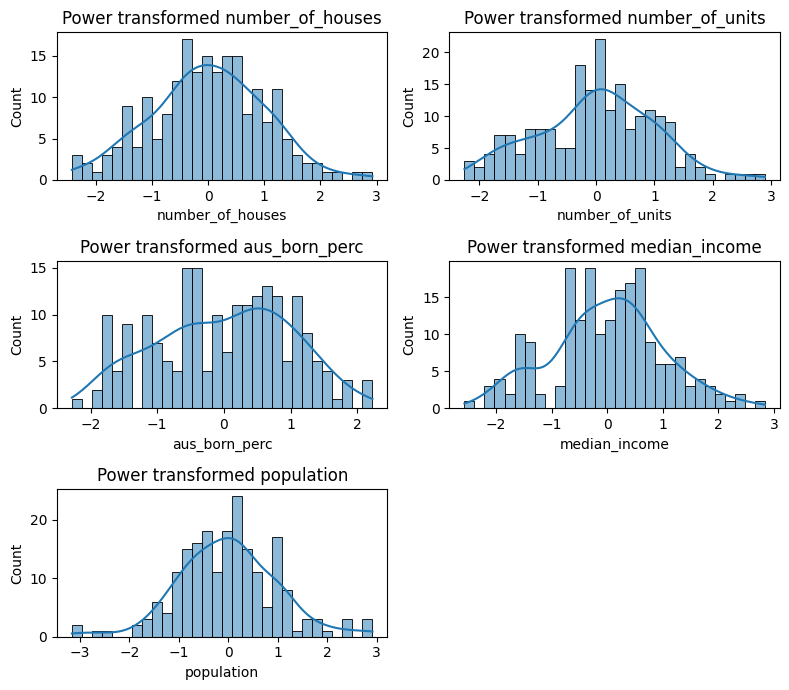

In [222]:
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data_power[feature], bins=30, kde=True)
    plt.title(f'Power transformed {feature}')
plt.tight_layout()
plt.show()

The features also show improved linear relationships with median_house_price, similar to the log transformation

### 3.2.6. Log transformation followed by Standardization <a class="anchor" name="ls"></a>

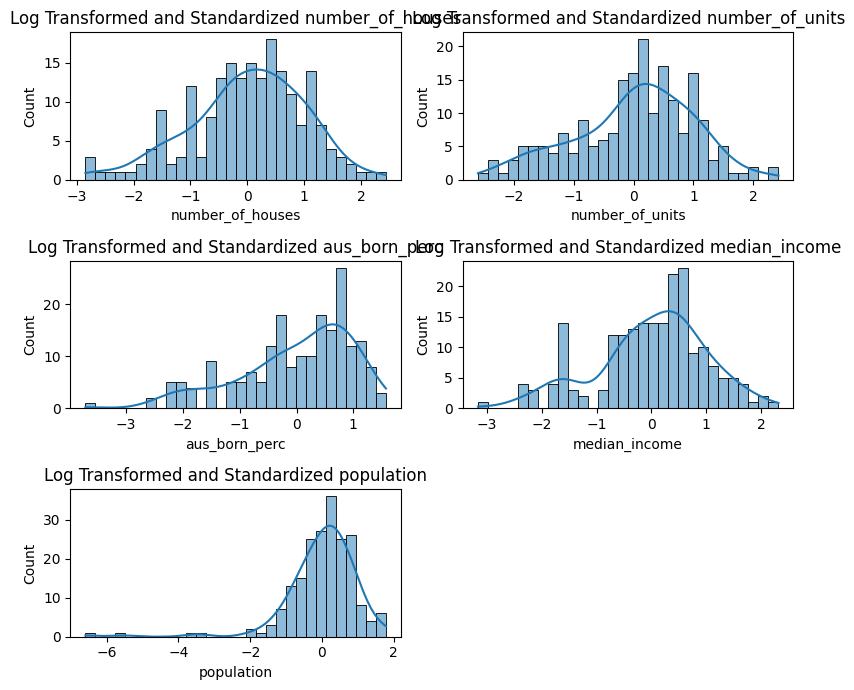

In [223]:
# Log Transformation followed by Standardization
log_standardized_data = data.copy()
for feature in features:
    log_transformed = np.log(data[feature] + 1e-9)
    log_standardized_data[feature] = scaler.fit_transform(log_transformed.values.reshape(-1, 1))

# Plot histograms for log-transformed and standardized features
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(log_standardized_data[feature], bins=30, kde=True)
    plt.title(f'Log Transformed and Standardized {feature}')
plt.tight_layout()
plt.show()

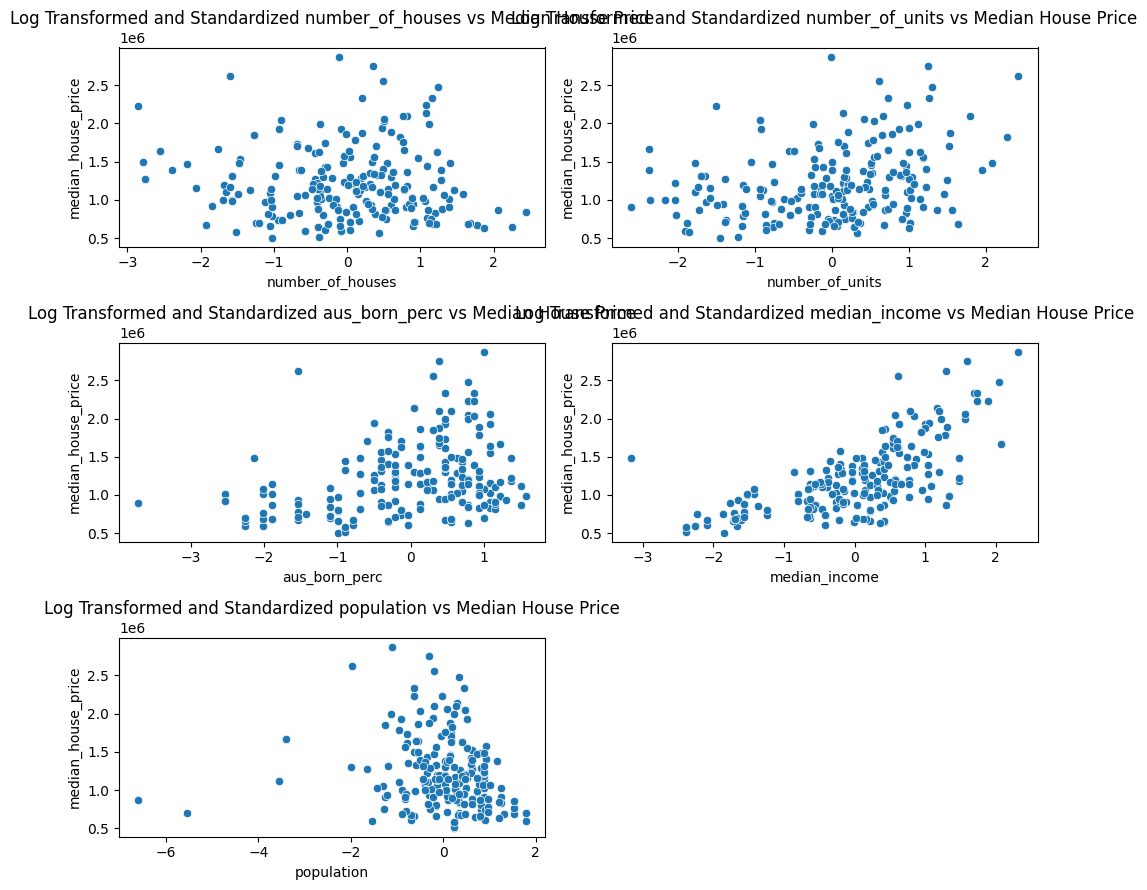

In [224]:
# Plot scatter plots for log-transformed and standardized features against median_house_price
plt.figure(figsize=(10, 9))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=log_standardized_data[feature], y=data['median_house_price'])
    plt.title(f'Log Transformed and Standardized {feature} vs Median House Price')
plt.tight_layout()
plt.show()

### 3.2.7. Power transformation followed by Min-Max Normalisation <a class="anchor" name="pm"></a>

We also tried applying combination of transformation to see if the the combination transformation better at rescaling the variables distribution

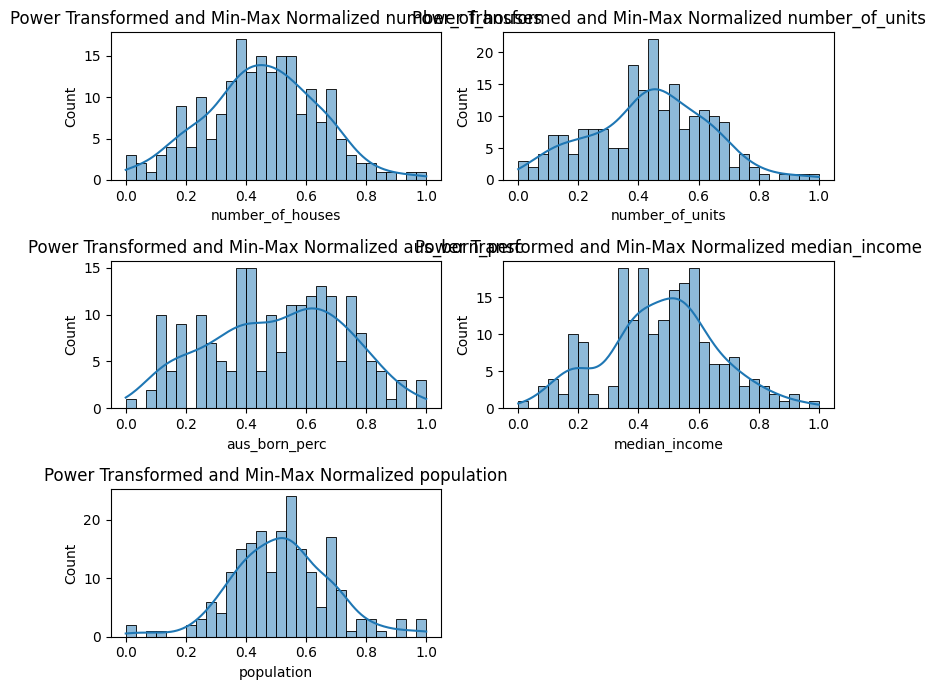

In [225]:
# Power Transformation followed by Min-Max Normalization
power_normalized_data = data.copy()
for feature in features:
    power_transformed = power_transformer.fit_transform(data[[feature]])
    power_normalized_data[feature] = min_max_scaler.fit_transform(power_transformed)

# Plot histograms for power-transformed and min-max normalized features
plt.figure(figsize=(8, 7))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(power_normalized_data[feature], bins=30, kde=True)
    plt.title(f'Power Transformed and Min-Max Normalized {feature}')
plt.tight_layout()
plt.show()

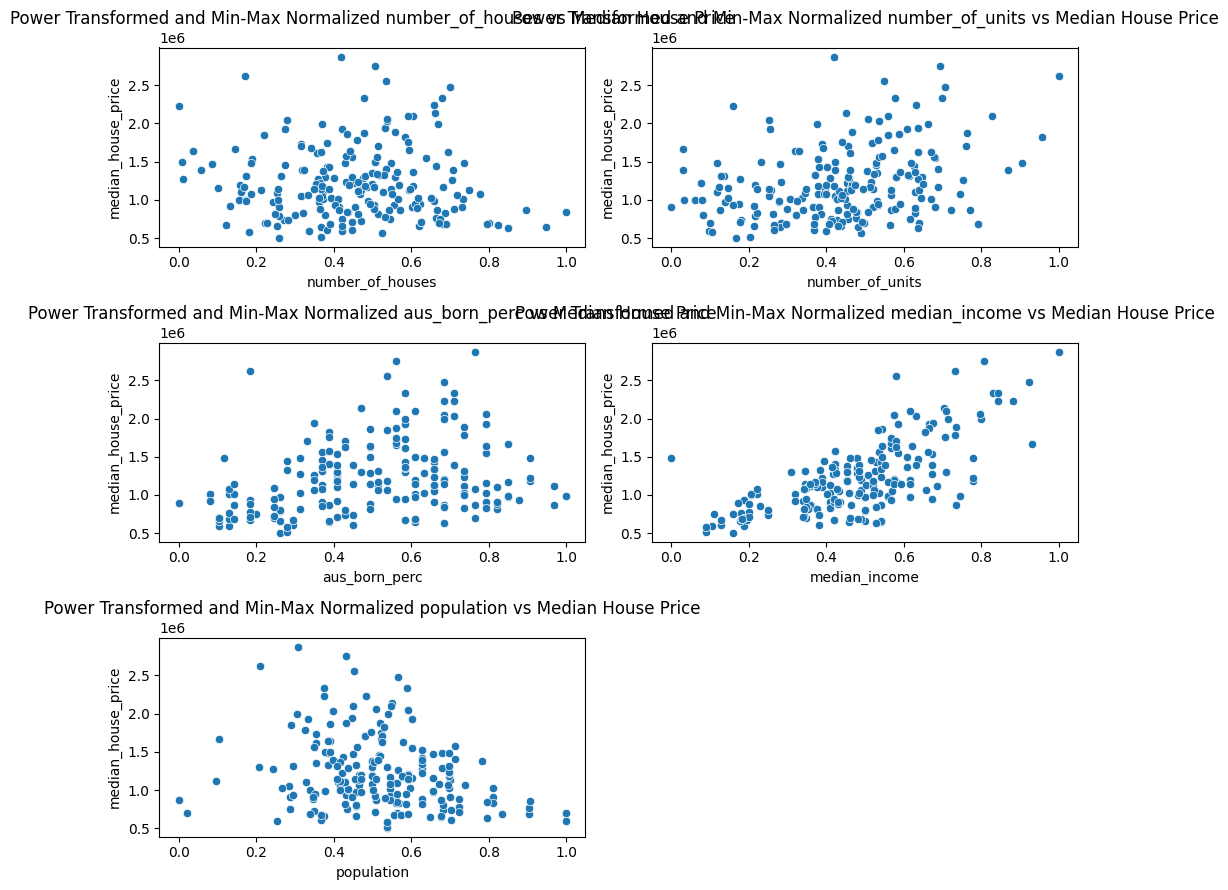

In [226]:
# Plot scatter plots for power-transformed and min-max normalized features against median_house_price
plt.figure(figsize=(10, 9))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x = power_normalized_data[feature], y = data['median_house_price'])
    plt.title(f'Power Transformed and Min-Max Normalized {feature} vs Median House Price')
plt.tight_layout()
plt.show()

## 3.3. Conclusion <a class="anchor" name="con"></a>

> For `number_of_houses` and `number_of_units`:
   - Avoid Min-Max Scaling and Standardization as these methods might not effectively capture the distribution of these variables.
   - Other transformation methods such as Log, Box-Cox, or Power transformations are more suitable, potentially because they can handle skewness better and normalize the distribution.

> For `median_income`:

   - It’s recommended to avoid transformations. The original scale of median_income already provides a suitable representation for modeling without the need for further normalization or transformation.

> For `population`:
   - Log transformation should be avoided, which might imply it over-corrects the distribution, potentially underrepresenting the variable’s impact or creating non-linearity in its relationship with median_house_price.
   - Other methods might be more suitable to address any issues of scale or distribution without distorting the data relationships.

>  For `aus_born_perc`: It seems that any transformation method is acceptable for `aus_born_perc`
